In [1]:
import os, gc, datetime, time
import pandas as pd, numpy as np
from tqdm import tqdm_notebook
import lightgbm as lgb

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8] # setting figure size

sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

In [3]:
import pickle

import os, sys, gc 
from plotnine import *
import plotnine

import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import re
from matplotlib.ticker import PercentFormatter
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import roc_auc_score

### 데이터 로드 

In [4]:
train_trans = pd.read_csv("./input/train_transaction.csv")
train_idf = pd.read_csv("./input/train_identity.csv")

test_trans = pd.read_csv("./input/test_transaction.csv")
test_idf = pd.read_csv("./input/test_identity.csv")

In [5]:
train_trans['TransactionDay'] = train_trans['TransactionDT'] // (24*60*60)
test_trans['TransactionDay'] = test_trans['TransactionDT'] // (24*60*60)

for i in range(1, 16): 
    # i가 9이면 hour를 의미해서 패스 
    if i != 9: 
        train_trans['D{}n'.format(i)] = train_trans['TransactionDay'] - train_trans['D{}'.format(i)]
        test_trans['D{}n'.format(i)] = test_trans['TransactionDay'] - test_trans['D{}'.format(i)]

In [6]:
train_trans[(train_trans['card1'] == 18383) & (train_trans['card2'] == 128) & (train_trans['card3'] == 150) & (train_trans['card4'] == 'visa') & (train_trans['card5'] == 226) & (train_trans['card6'] == 'credit')]

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
77340         3064340        0        1699373          107.95         W   
90370         3077370        0        1887400          150.00         R   
162642        3149642        0        3444196           30.95         W   
232040        3219040        0        5504516           42.95         W   
336013        3323013        0        8275288           57.95         W   
425671        3412671        0       10772608           57.95         W   
511094        3498094        0       13378525           57.95         W   

        card1  card2  card3 card4  card5   card6  addr1  addr2  dist1  dist2  \
77340   18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    NaN   
90370   18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    2.0   
162642  18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    NaN   
232040  18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    NaN   
336013  18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    NaN   
425671  18383  128.0  150.0  visa  226.0  credit  264.0   87.0    NaN    NaN   
511094  18383  128.0  150.0  visa  226.0  credit  264.0   87.0   11.0    NaN   

        P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
77340       gmail.com            NaN  2.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   
90370   anonymous.com  anonymous.com  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0   
162642      gmail.com            NaN  2.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   
232040      gmail.com            NaN  3.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   
336013      gmail.com            NaN  3.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   
425671      gmail.com            NaN  3.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   
511094      gmail.com            NaN  3.0  2.0  0.0  0.0  1.0  2.0  0.0  0.0   

         C9  C10  C11  C12   C13  C14     D1     D2     D3     D4    D5  \
77340   0.0  0.0  2.0  0.0  17.0  2.0  405.0  405.0   21.0  405.0  21.0   
90370   0.0  1.0  1.0  0.0   1.0  1.0  371.0  371.0  371.0    0.0   NaN   
162642  0.0  0.0  2.0  0.0  18.0  2.0  425.0  425.0   20.0  425.0  20.0   
232040  0.0  0.0  2.0  0.0  18.0  3.0  449.0  449.0   24.0  449.0  24.0   
336013  2.0  0.0  2.0  0.0  20.0  3.0  481.0  481.0   32.0  481.0  32.0   
425671  3.0  0.0  2.0  0.0  20.0  3.0  510.0  510.0   29.0  510.0  29.0   
511094  3.0  0.0  2.0  0.0  22.0  3.0  540.0  540.0   30.0  540.0  30.0   

           D6     D7  D8  D9    D10   D11  D12  D13  D14    D15   M1   M2  \
77340     NaN    NaN NaN NaN  441.0   NaN  NaN  NaN  NaN  405.0  NaN  NaN   
90370   371.0  371.0 NaN NaN  371.0   NaN  NaN  NaN  0.0    NaN  NaN  NaN   
162642    NaN    NaN NaN NaN  461.0   NaN  NaN  NaN  NaN  425.0  NaN  NaN   
232040    NaN    NaN NaN NaN  485.0   NaN  NaN  NaN  NaN  449.0  NaN  NaN   
336013    NaN    NaN NaN NaN  517.0   0.0  NaN  NaN  NaN  481.0    T    T   
425671    NaN    NaN NaN NaN  546.0   0.0  NaN  NaN  NaN  510.0    T    F   
511094    NaN    NaN NaN NaN  576.0  59.0  NaN  NaN  NaN  540.0    T    T   

         M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7  \
77340   NaN  NaN  NaN    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
90370   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
162642  NaN  NaN  NaN    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
232040  NaN  NaN  NaN    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
336013    T  NaN  NaN    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
425671    F  NaN  NaN    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
511094    T  NaN  NaN    T    F    T    T  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

         V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  \
77340   NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
90370   NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
162642  NaN  NaN  NaN  NaN

In [6]:
agg = train_trans.groupby(['card1', 'addr1', 'D1n'])['isFraud'].agg({'mean','count'}).reset_index()
agg[(agg['mean'] > 0) & (agg['mean'] != 1)].sort_values(by=['count', 'mean'], ascending=[False, False])

card1  addr1    D1n      mean  count
137764  12695  325.0 -342.0  0.731707    123
98960    9500  330.0   17.0  0.903614     83
139449  12839  264.0   40.0  0.016949     59
183595  16998  330.0  -37.0  0.051724     58
139445  12839  264.0   36.0  0.017241     58
...       ...    ...    ...       ...    ...
188196  17321  472.0  166.0  0.500000      2
190052  17480  299.0  152.0  0.500000      2
192493  17868  472.0  102.0  0.500000      2
195237  18132  337.0  120.0  0.500000      2
197891  18268  485.0    8.0  0.500000      2

[1232 rows x 5 columns]

In [7]:
agg = agg[agg['mean'] == 1].sort_values(by=['count', 'mean'], ascending=[False, False])
agg.head()

card1  addr1    D1n  mean  count
185362  17188  122.0 -139.0   1.0     84
146715  13623  498.0  117.0   1.0     80
92234    9002  272.0  -92.0   1.0     78
24959    2939  204.0 -137.0   1.0     76
101019   9749  226.0   -5.0   1.0     60

In [8]:
train_trans[(train_trans['card1'] == 15775) & (train_trans['D1n'] == -81)][['TransactionID', 'isFraud', 'TransactionAmt', 'card1', 'addr1', 'D1n','TransactionDay' ,'D3n', 'dist1', 'P_emaildomain']]

TransactionID  isFraud  TransactionAmt  card1  addr1   D1n  \
1694         2988694        1           240.0  15775  251.0 -81.0   
10046        2997046        1           260.0  15775  251.0 -81.0   
34029        3021029        1           250.0  15775  251.0 -81.0   
36812        3023812        1           315.0  15775  251.0 -81.0   
40459        3027459        1           390.0  15775  251.0 -81.0   
43926        3030926        1           475.0  15775  251.0 -81.0   
43941        3030941        1           445.0  15775  251.0 -81.0   
44717        3031717        1           445.0  15775  251.0 -81.0   
44727        3031727        1           445.0  15775  251.0 -81.0   
58485        3045485        1           295.0  15775  251.0 -81.0   

       TransactionDay   D3n  dist1 P_emaildomain  
1694                1   0.0    NaN     yahoo.com  
10046               3   1.0    NaN     yahoo.com  
34029               9   3.0    NaN     yahoo.com  
36812              10   9.0    NaN     yahoo.com  
40459              11  10.0    NaN     yahoo.com  
43926              12  11.0    NaN     yahoo.com  
43941              12  12.0    NaN     yahoo.com  
44717              12  12.0    NaN     yahoo.com  
44727              12  12.0   12.0           NaN  
58485              15  12.0    NaN     yahoo.com

In [9]:
train_trans['is_this_transaction_in_test_data'] = 'train'
test_trans['is_this_transaction_in_test_data'] = 'test'
total_trans = pd.concat([train_trans, test_trans], axis=0, sort=False)

In [13]:
(ggplot(data = total_trans) 
     + geom_point(aes(x='TransactionDT', y ='D1', group='is_this_transaction_in_test_data', colour='is_this_transaction_in_test_data'), alpha = 0.2)
     + theme_minimal()
     + ggtitle("Train/Test D1 variable") 
     + labs(x = "TransactionDT") 
     + theme(legend_position = "none", figure_size=(12,6))
) 


C:\Users\choco\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\choco\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: Train/Test D1 variable.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\choco\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 7300 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


FileNotFoundError: [Errno 2] No such file or directory: 'Train/Test D1 variable.png'

In [15]:
# Data Merge
train_df = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
test_df = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

In [16]:
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

C:\Users\choco\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
id_feature = [ c for c in train_df.columns if c.find('id_') !=-1]
v_feature = [ c for c in train_df.columns if c.find('V') !=-1]
card_feature = [ c for c in train_df.columns if c.find('card') !=-1]
C_feature = [ c for c in train_df.columns if c.find('C') !=-1 and c != 'ProductCD']
D_feature = [ c for c in train_df.columns if c.find('n') == -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
Dn_feature = [ c for c in train_df.columns if c.find('n') != -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
M_feature = [ c for c in train_df.columns if c.find('M') !=-1]

In [18]:
total_df = pd.concat([train_df, test_df], axis=0, sort=False)
target = total_df['is_this_transaction_in_test_data'].values
train, test = model_selection.train_test_split(total_df, test_size=0.33, random_state=42, shuffle=True)

train_y = train['is_this_transaction_in_test_data'].values
test_y = test['is_this_transaction_in_test_data'].values

# TransactionDT ~ M columns 
features = np.append(['TransactionDT', 'TransactionAmt', 'ProductCD'], card_feature + Dn_feature + C_feature + M_feature)
train_ = lgb.Dataset(train[features], label=train_y)
test_ = lgb.Dataset(test[features], label=test_y)

In [19]:
# 문제점
# 파라미터에 따라서 아래와 결과가 달라짐. 
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [20]:
num_round = 50
clf = lgb.train(params, train_, num_round, valid_sets = [train_, test_], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.999999	valid_1's auc: 0.999998
Did not meet early stopping. Best iteration is:
[22]	training's auc: 1	valid_1's auc: 0.999999


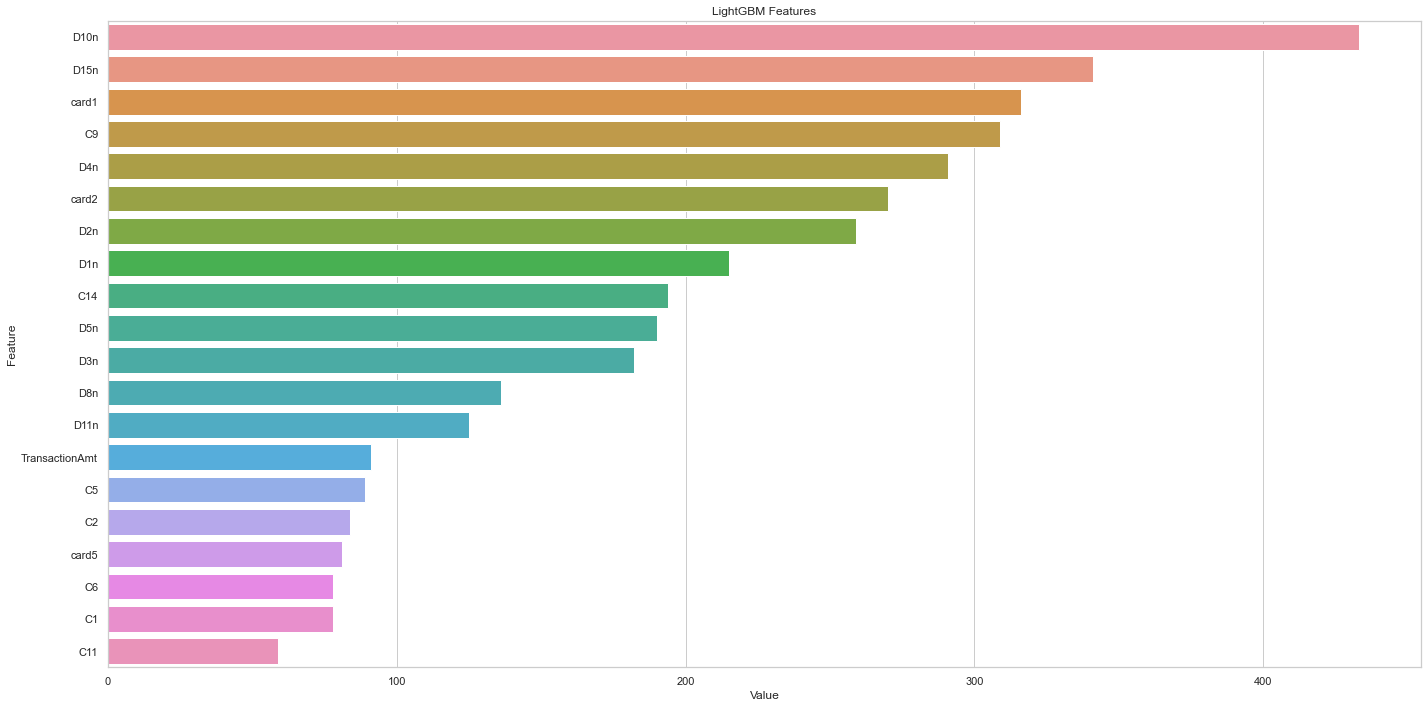

<Figure size 1152x576 with 0 Axes>

In [21]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [22]:
# TransactionDT ~ M columns 
features = v_feature
train_ = lgb.Dataset(train[features], label=train_y)
test_ = lgb.Dataset(test[features], label=test_y)

num_round = 50
clf = lgb.train(params, train_, num_round, valid_sets = [train_, test_], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.760991	valid_1's auc: 0.752336
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.760991	valid_1's auc: 0.752336


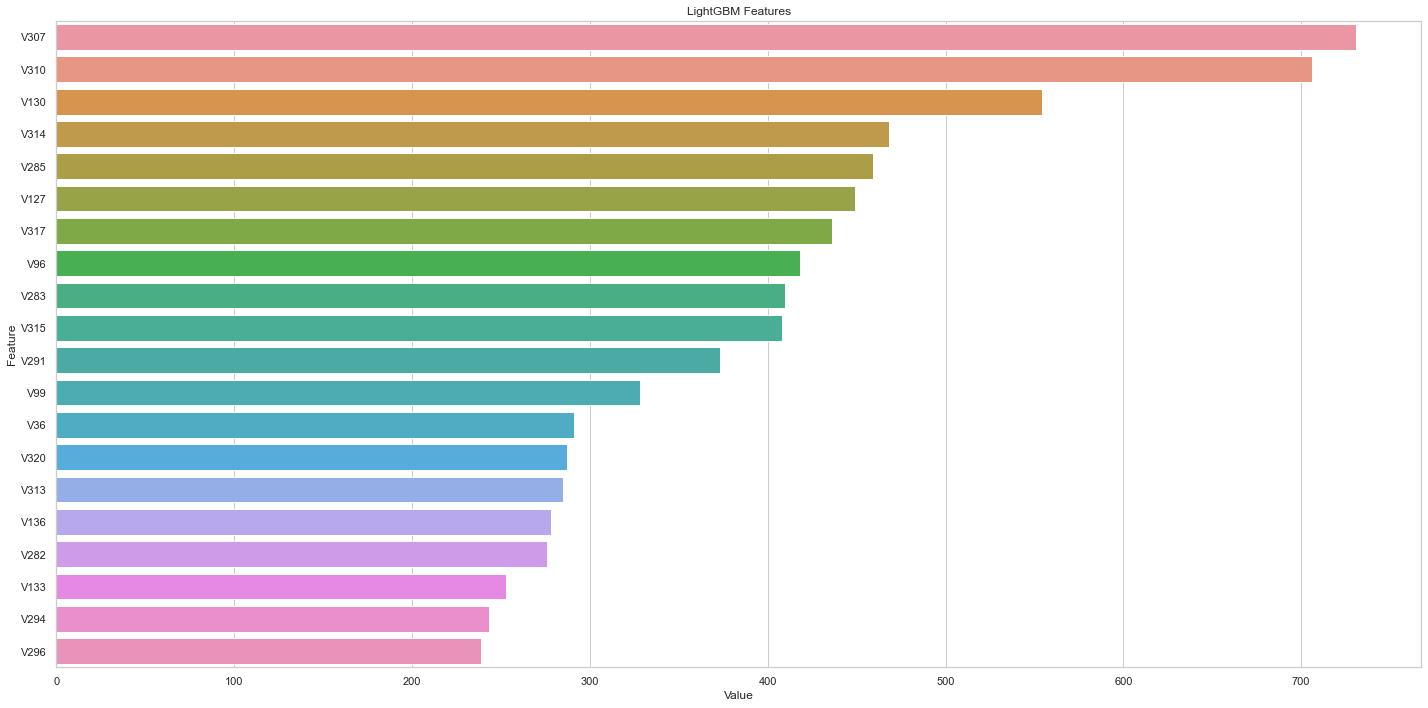

<Figure size 1152x576 with 0 Axes>

In [23]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-02.png')

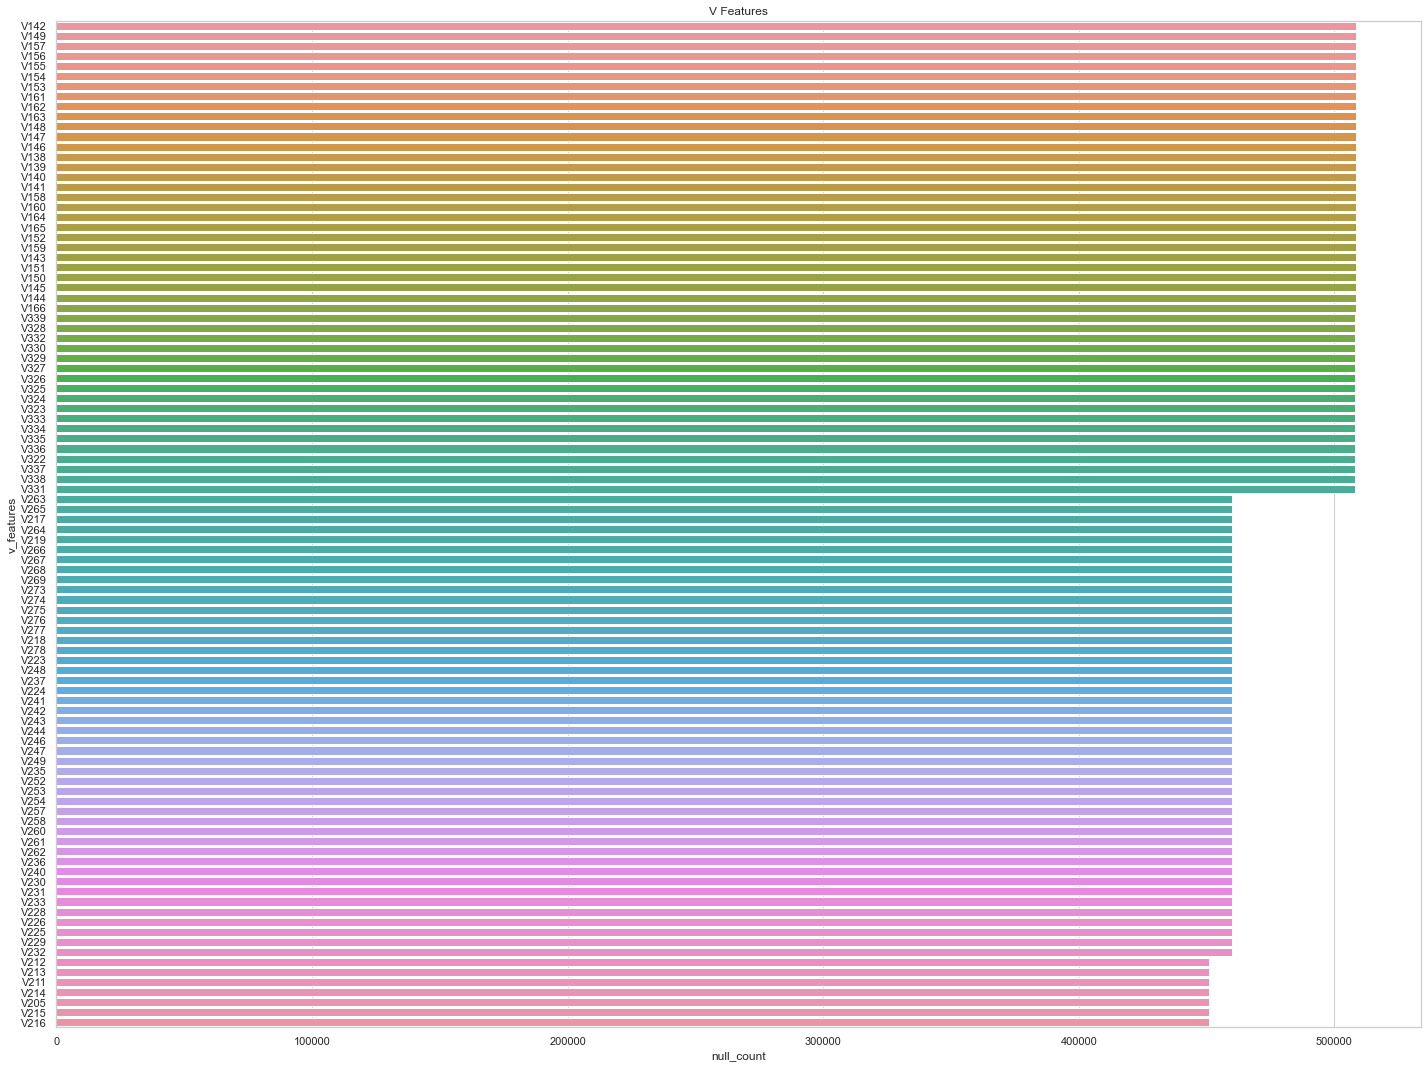

<Figure size 1152x576 with 0 Axes>

In [24]:
nullsum = pd.DataFrame(train_df[v_feature].isnull().sum()).reset_index()
nullsum.columns = ['v_features', 'null_count']

plt.figure(figsize=(20, 15))
sns.barplot(x="null_count", y="v_features", data=nullsum.sort_values(by="null_count", ascending=False).head(100))
plt.title('V Features')
plt.tight_layout()
plt.show()
plt.savefig('Null Count-03.png')

## EDA

In [25]:
nans_df = train_df.isna()
nans_groups={}

i_cols = ['V'+str(i) for i in range(1,340)]
for col in train_df.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'TransactionDay', 'is_this_transaction_in_test_data', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 4259
['card5']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315', 'D1n']
####### NAN count = 280797
['D2', 'D2n']
####### NAN count = 262878
['D3', 'D3n']
####### NAN count = 168922
['D4', 'D4n']
######

In [26]:
Vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
Vtitle = 'V279 - V321'
Vs = nans_groups[12]

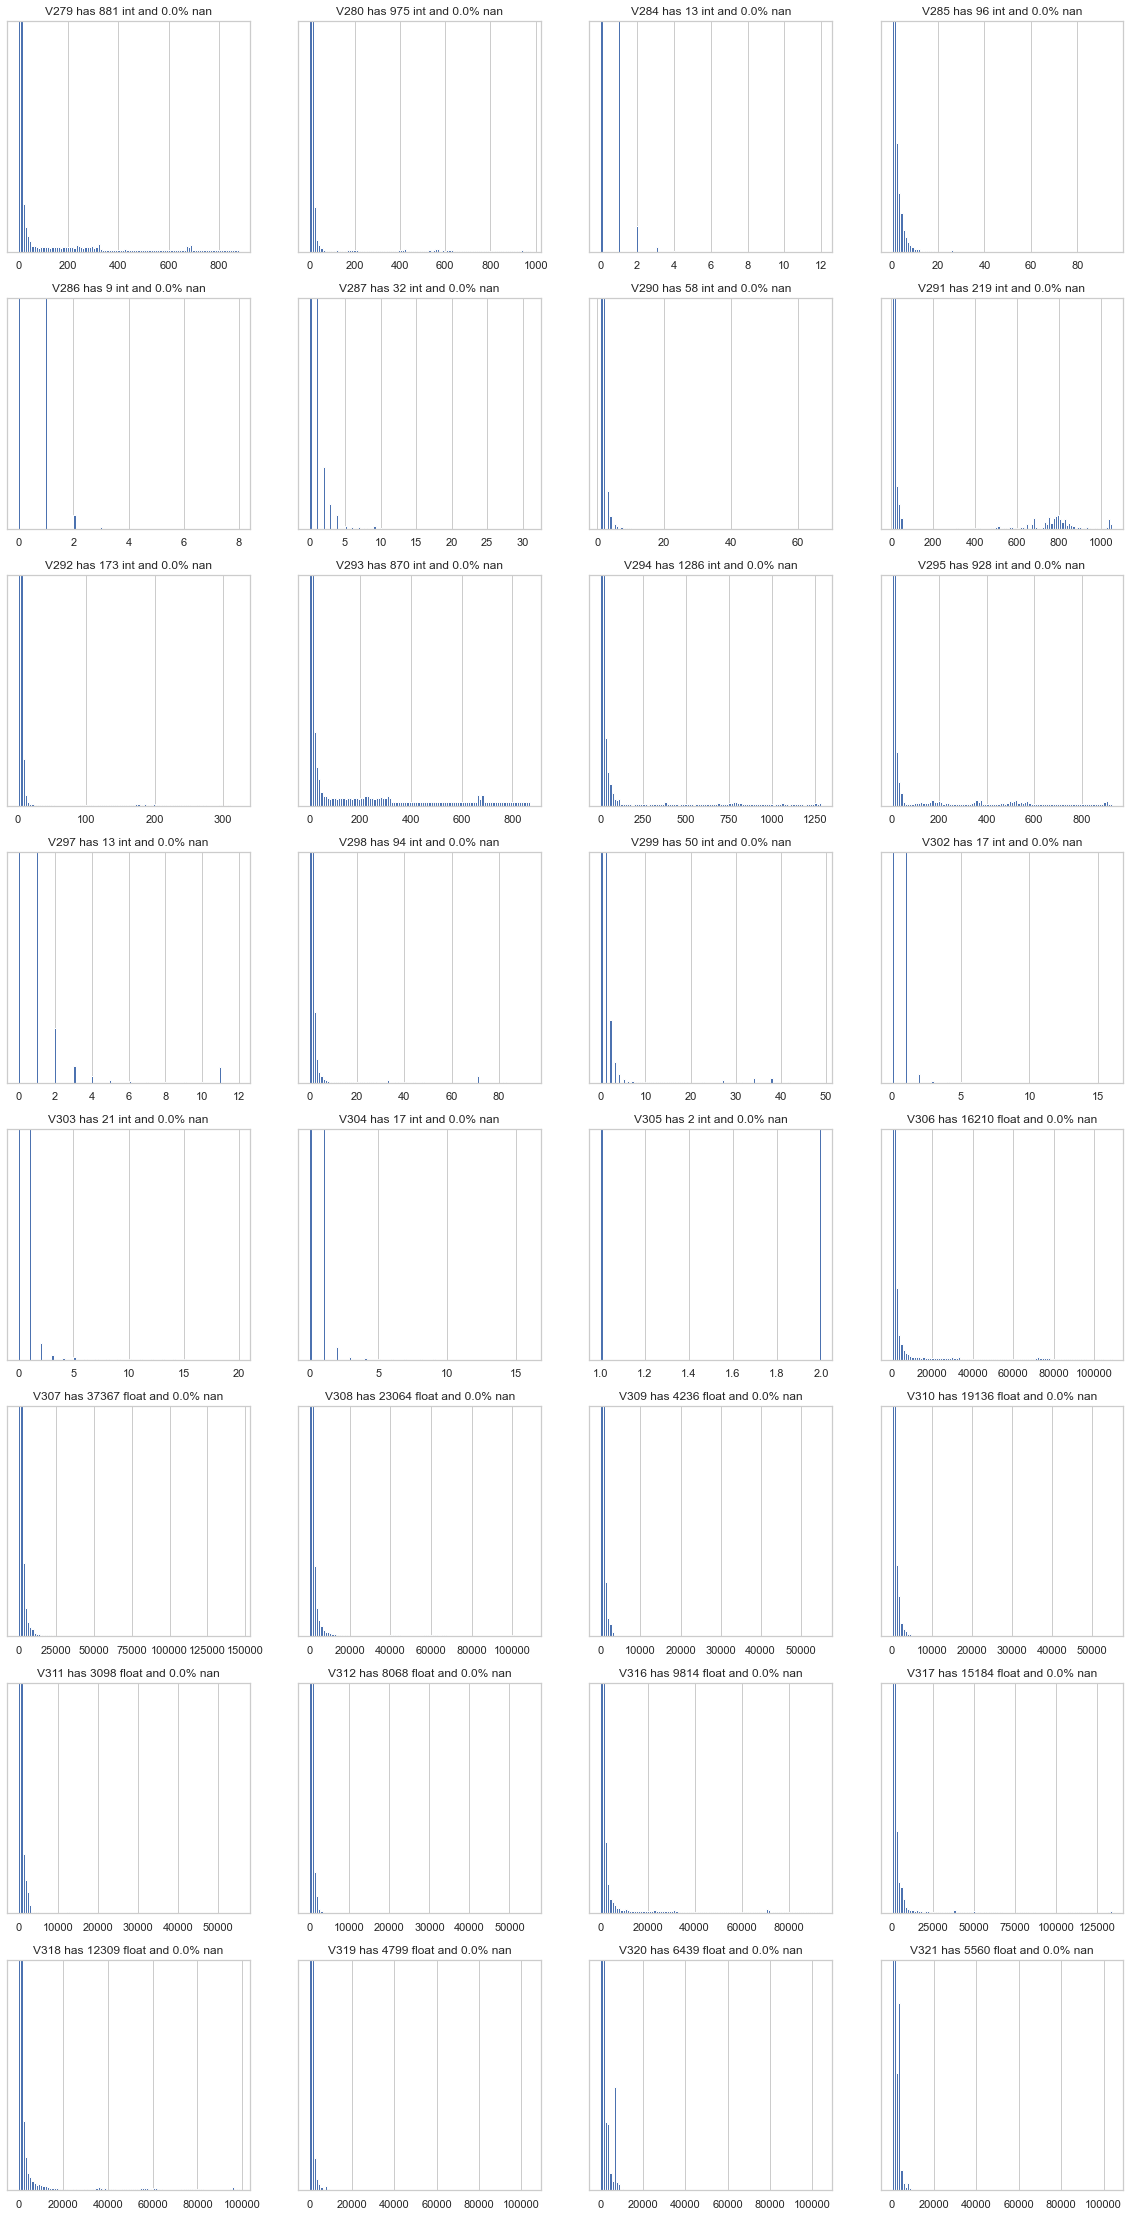

In [27]:
def make_plots(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    idx = train_df[~train_df[Vs[0]].isna()].index
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        n = train_df[v].nunique()
        x = np.sum(train_df.loc[idx,v]!=train_df.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train_df[v].isna())/len(train_df),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train_df.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
make_plots(Vs)

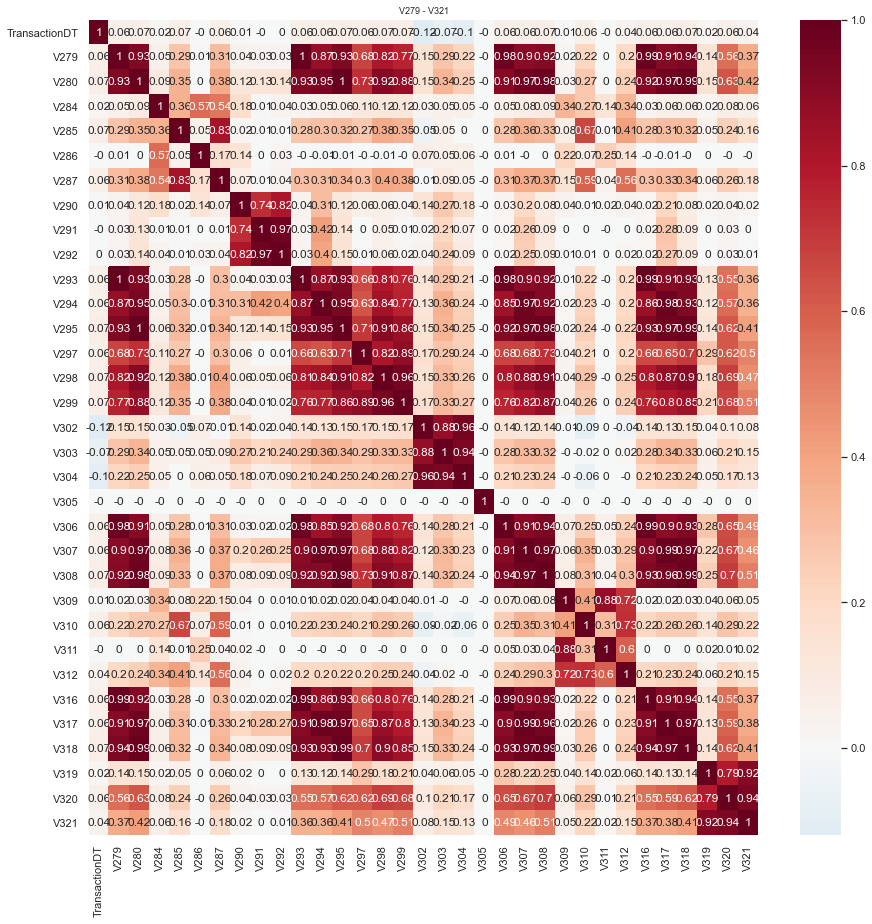

In [28]:
def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(np.around(train_df[cols].corr(),2), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=9)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=9)
    plt.show()
    
make_corr(Vs,Vtitle)

In [29]:
grps = [[279,280,293,294,295,298,299],[284],[285,287],[286],[290,291,292],[297], [302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[319,320,321]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train_df[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [294, 284, 285, 286, 291, 297, 303, 305, 307, 309, 310, 320]


V1-V11, D11

In [30]:
Vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
Vs = nans_groups[279287]
Vtitle = 'V1 - V11, D11'

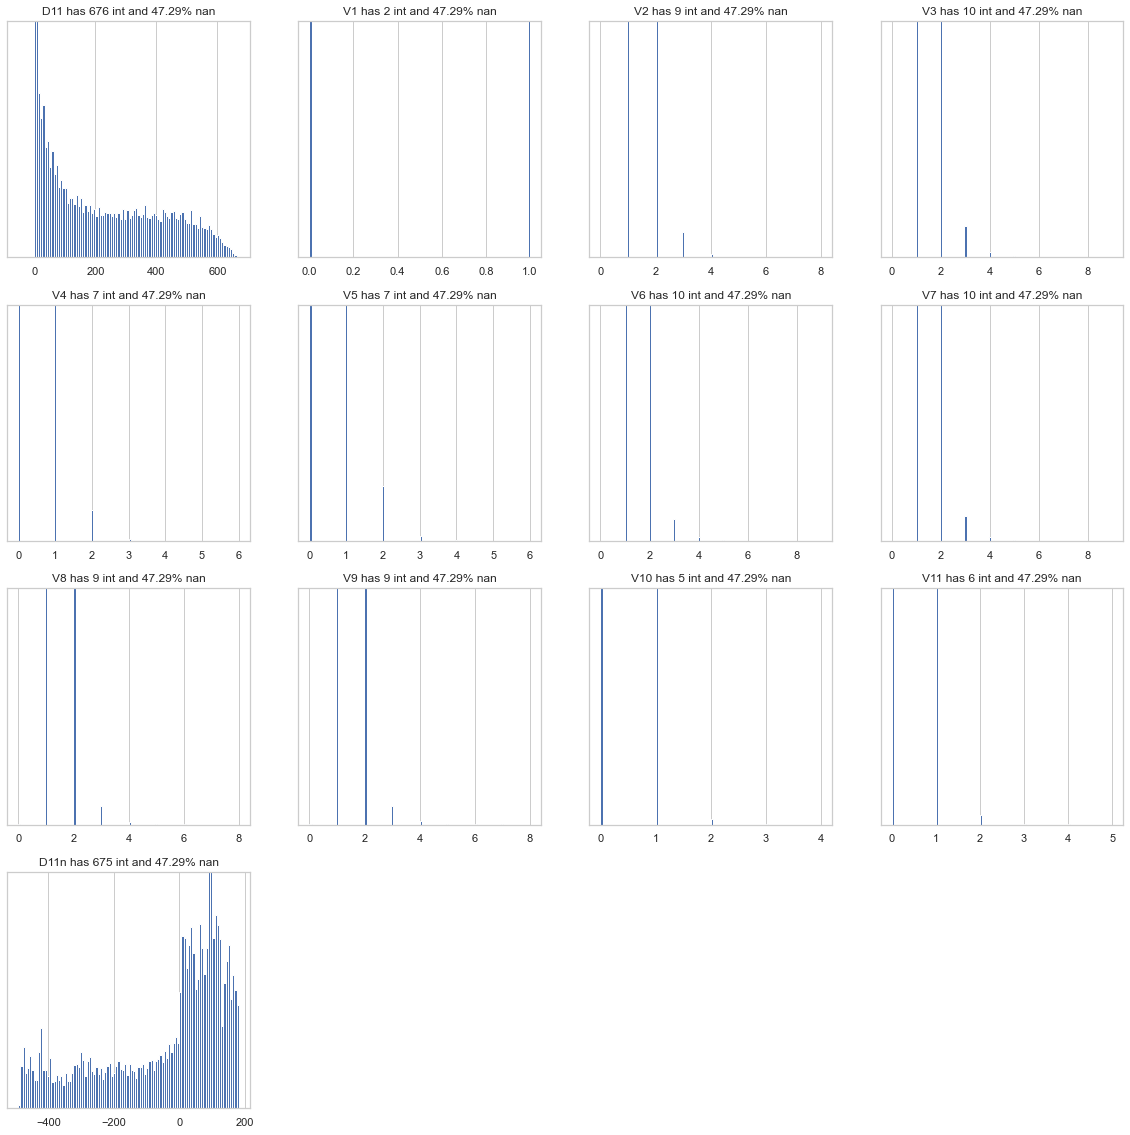

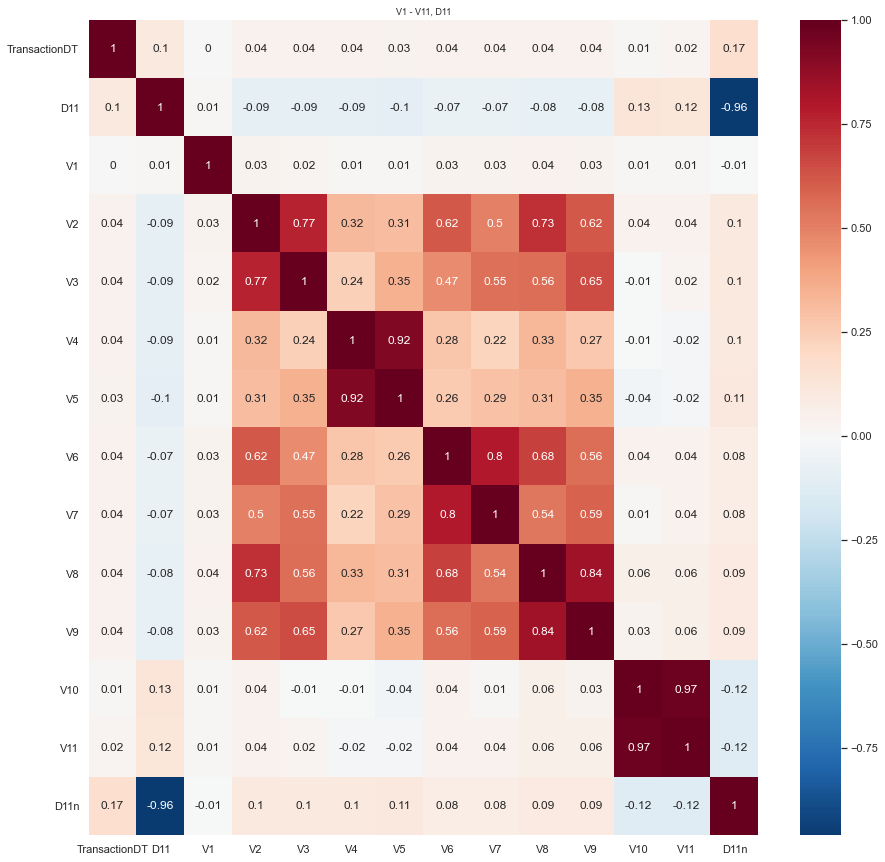

In [31]:
make_plots(Vs)
make_corr(Vs,Vtitle)

In [32]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]


### V12 - V34

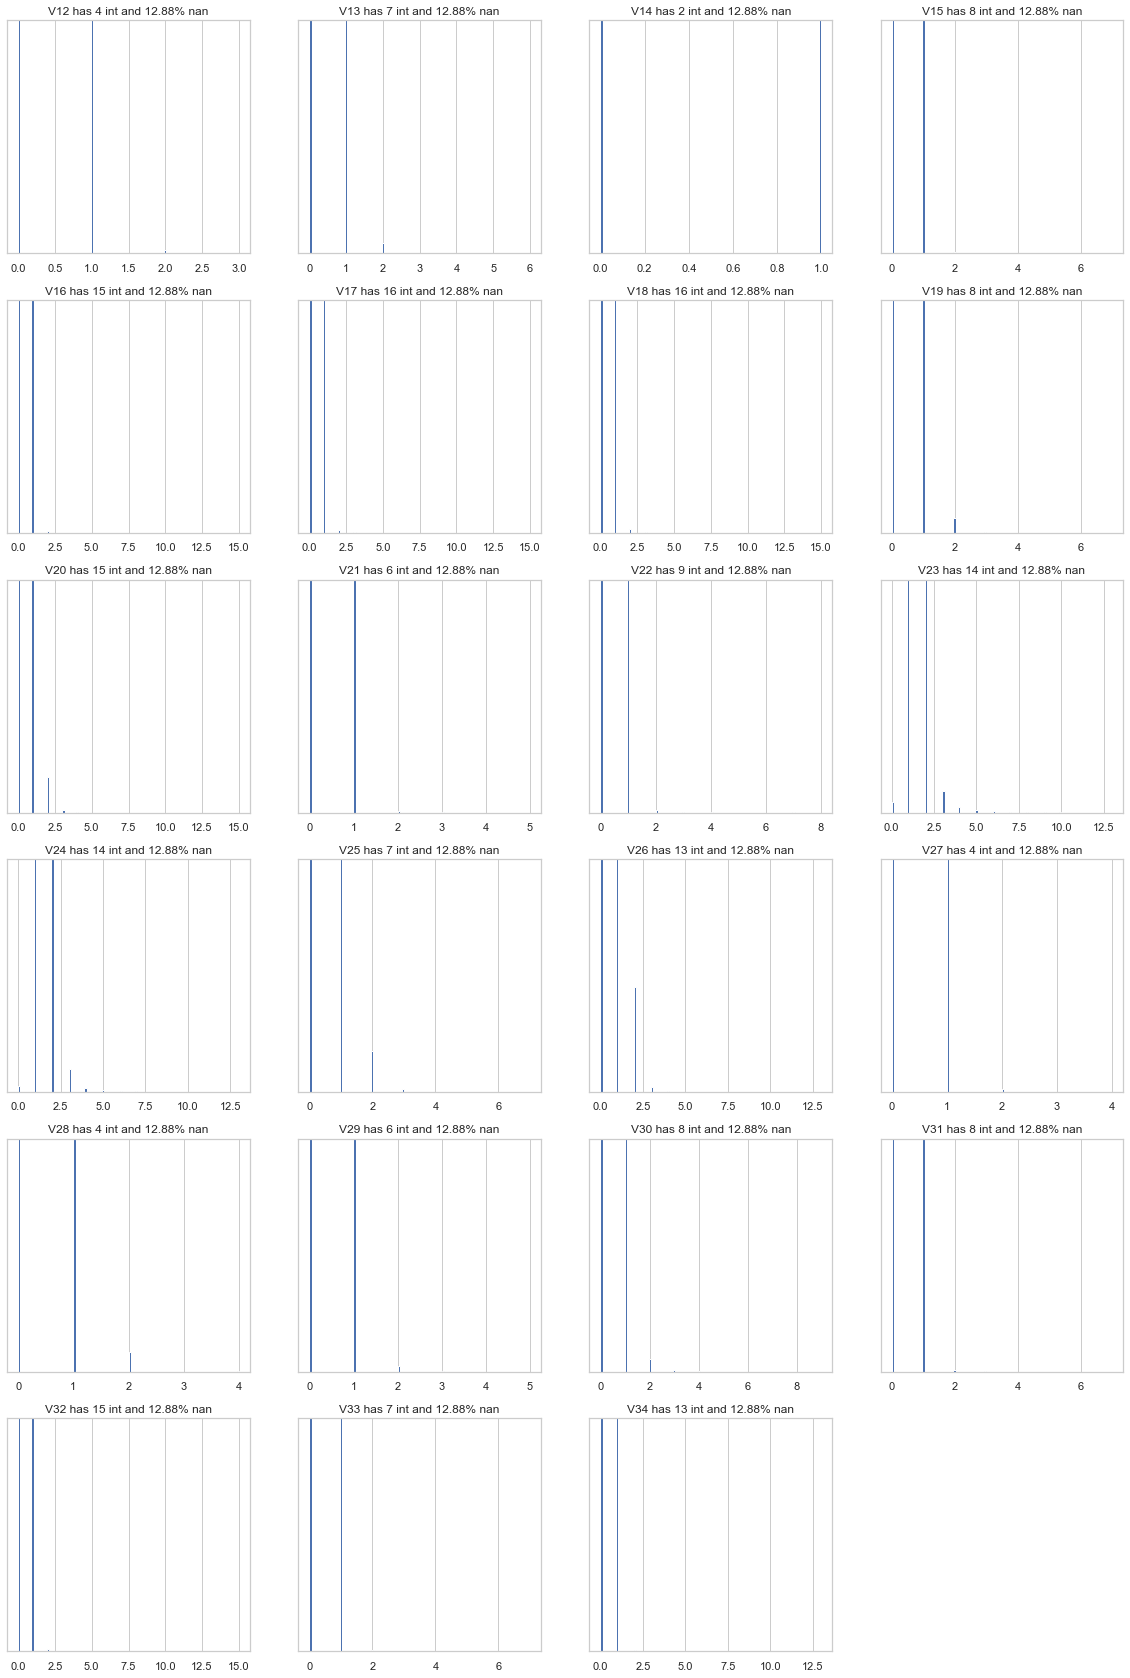

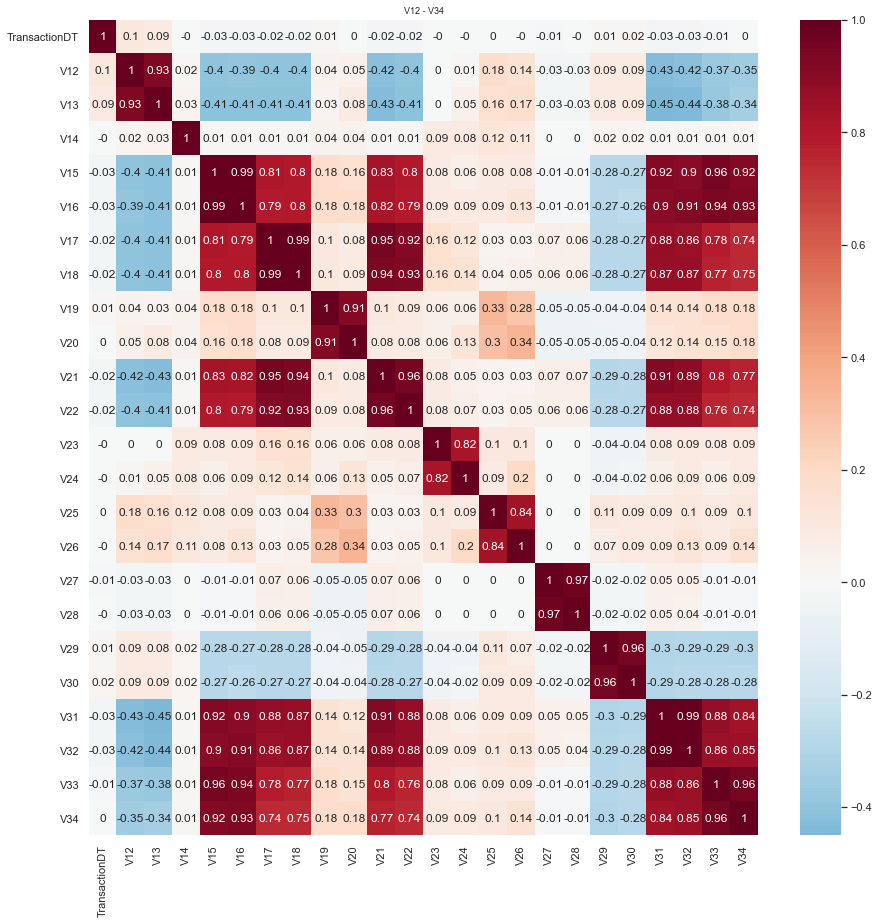

In [33]:
Vs = nans_groups[76073]
make_plots(Vs)
make_corr(Vs)

In [34]:
grps = [[12,13],[14],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],[29,30]]
reduce_group(grps)

Use these [13, 14, 17, 20, 23, 26, 27, 30]


### V35 - V52

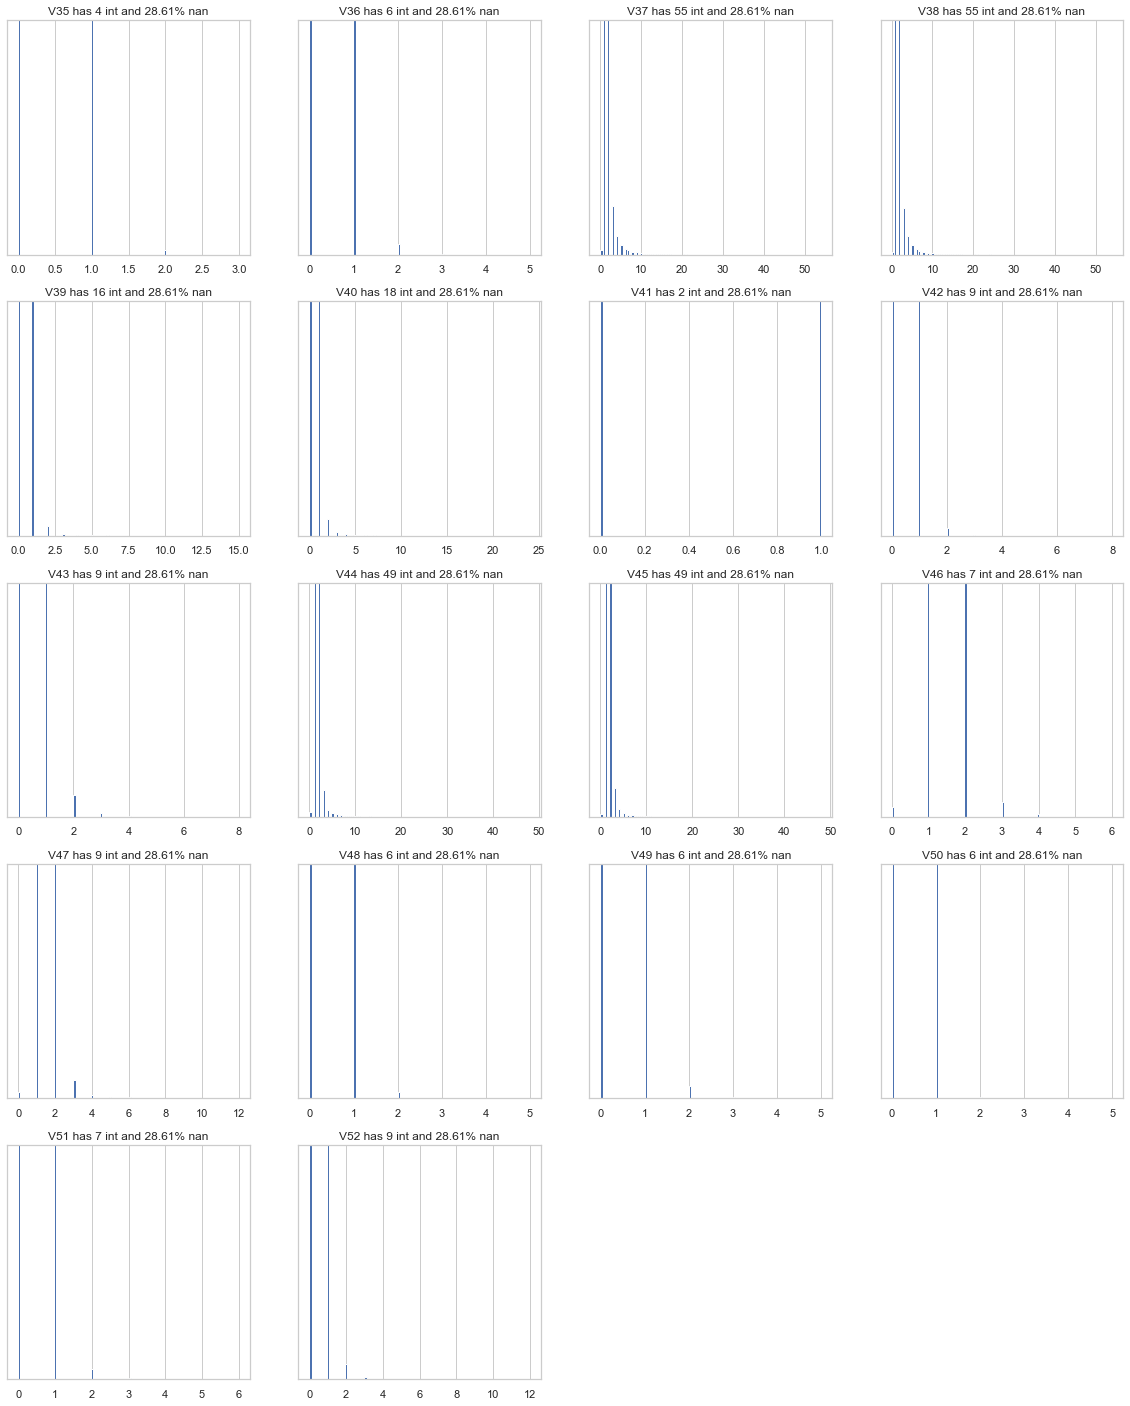

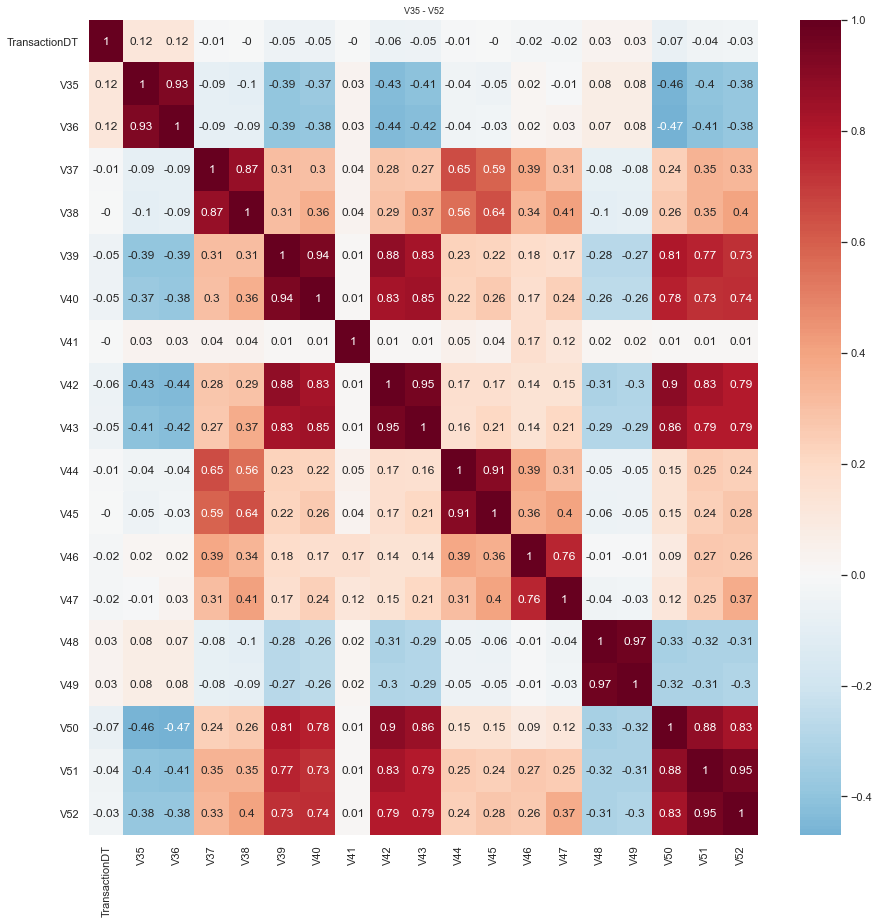

In [35]:
Vs = nans_groups[168969]
make_plots(Vs)
make_corr(Vs)

In [36]:
grps = [[35,36],[37,38],[39,40,42,43,50,51,52],[41],[44,45],[46,47],[48,49]]
reduce_group(grps)

Use these [36, 37, 40, 41, 44, 47, 48]


### V53 - V74

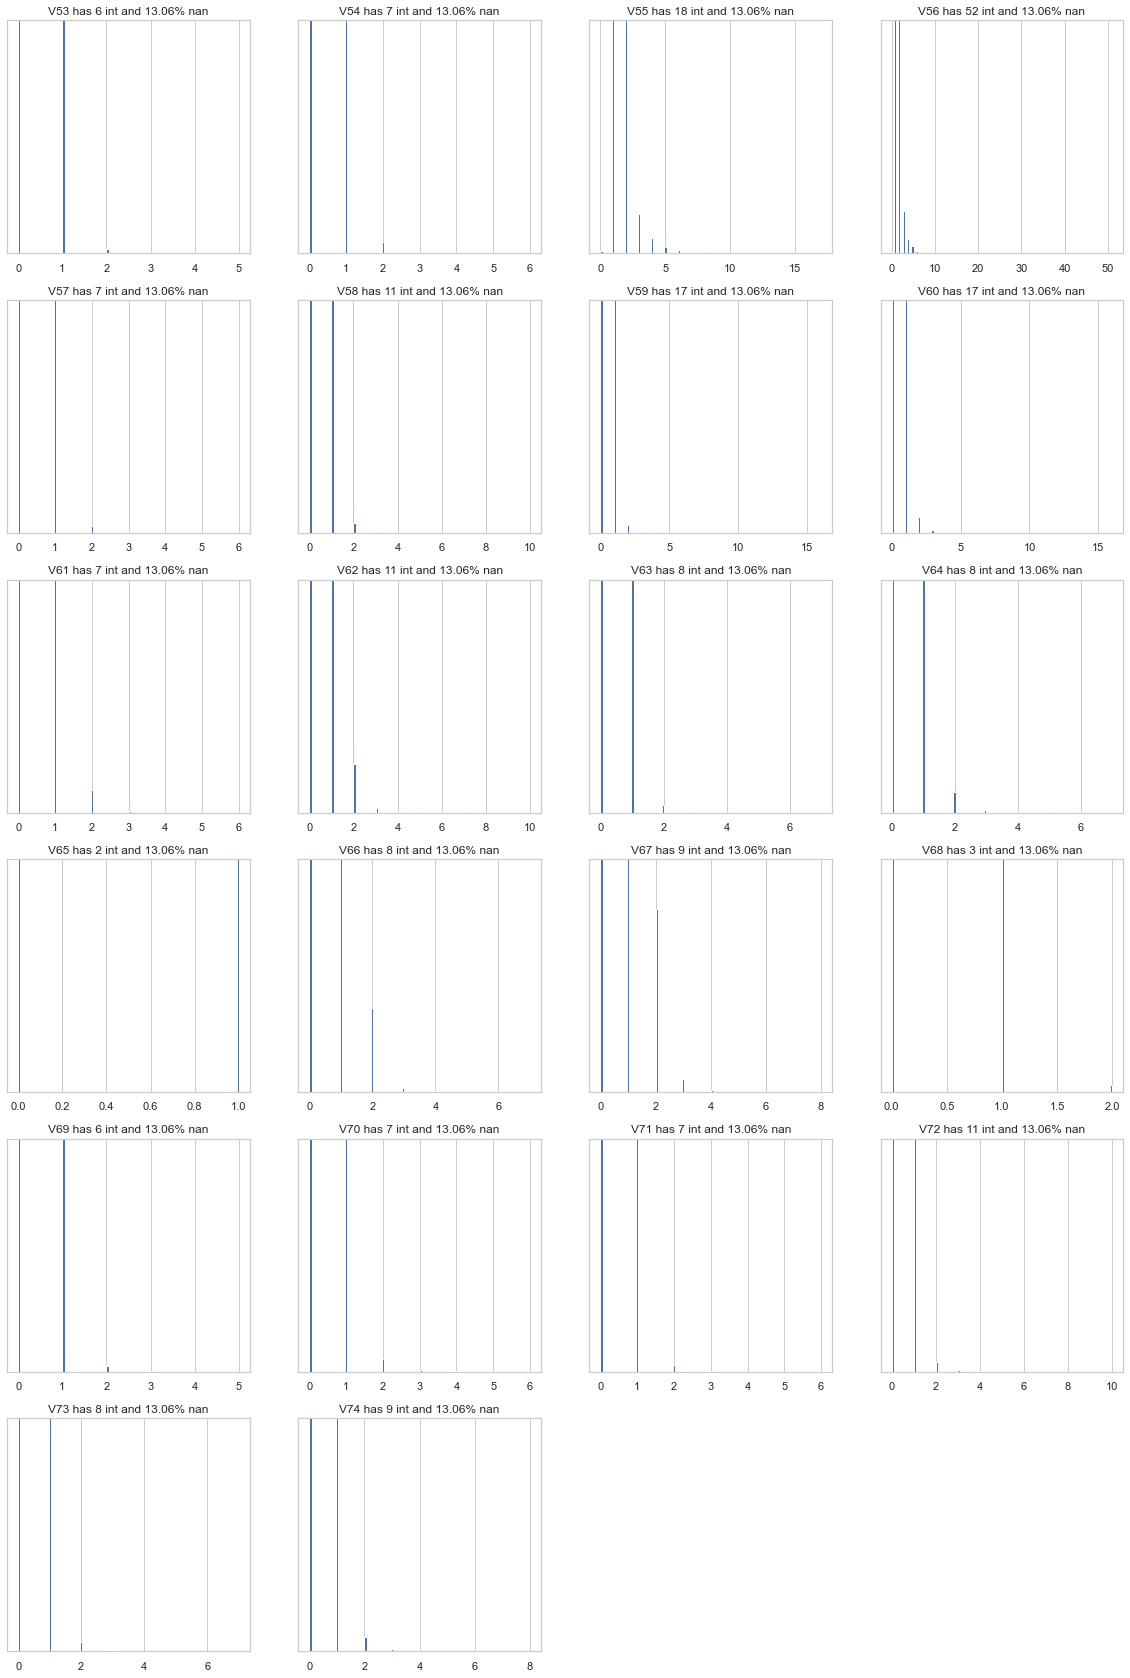

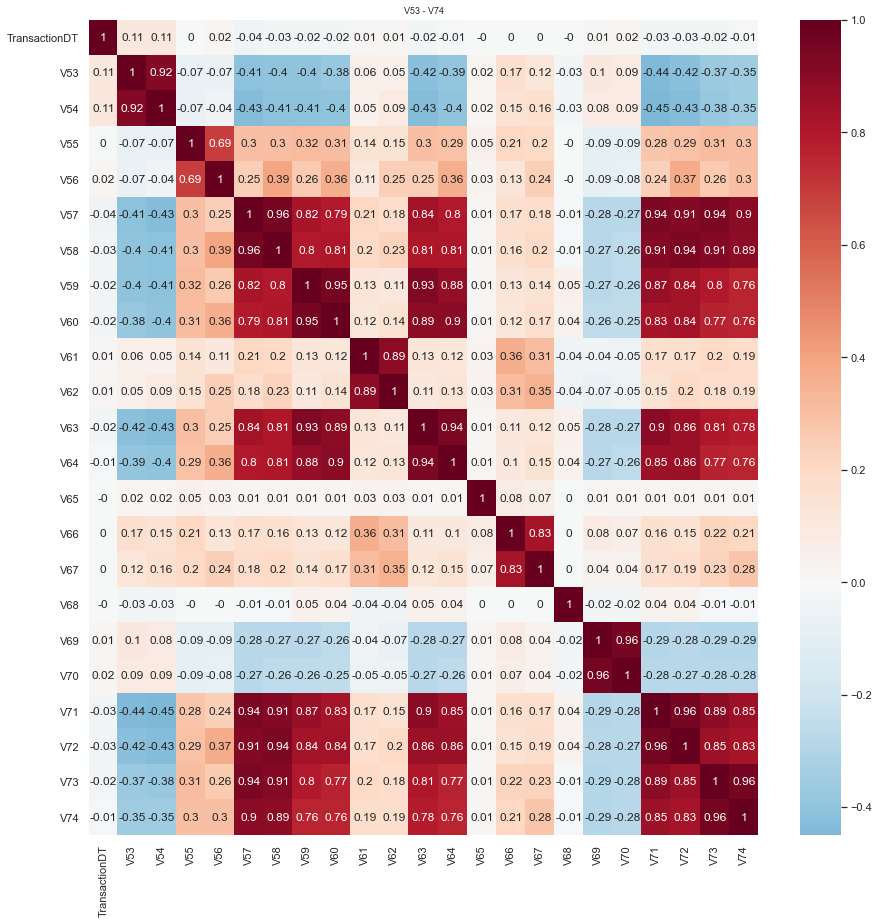

In [37]:
Vs = nans_groups[77096]
make_plots(Vs)
make_corr(Vs)

In [38]:
grps = [[53,54],[55,56],[57,58,59,60,63,64,71,72,73,74],[61,62],[65],[66,67],[68],[69,70]]
reduce_group(grps)

Use these [54, 56, 59, 62, 65, 67, 68, 70]


### V75 - V94

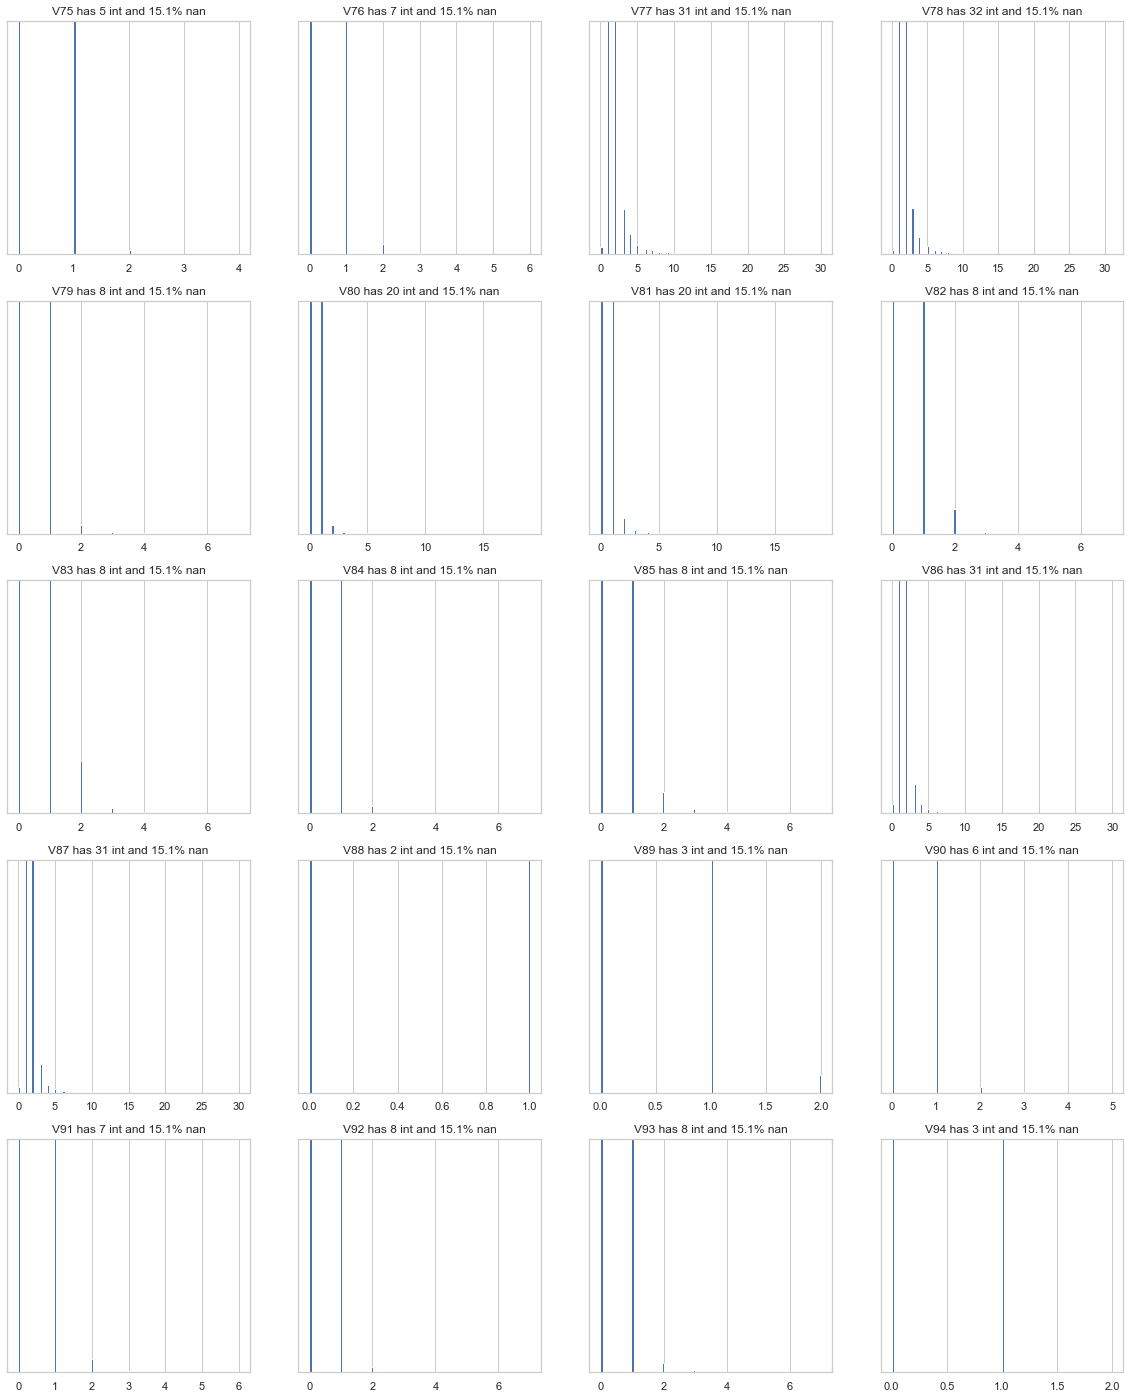

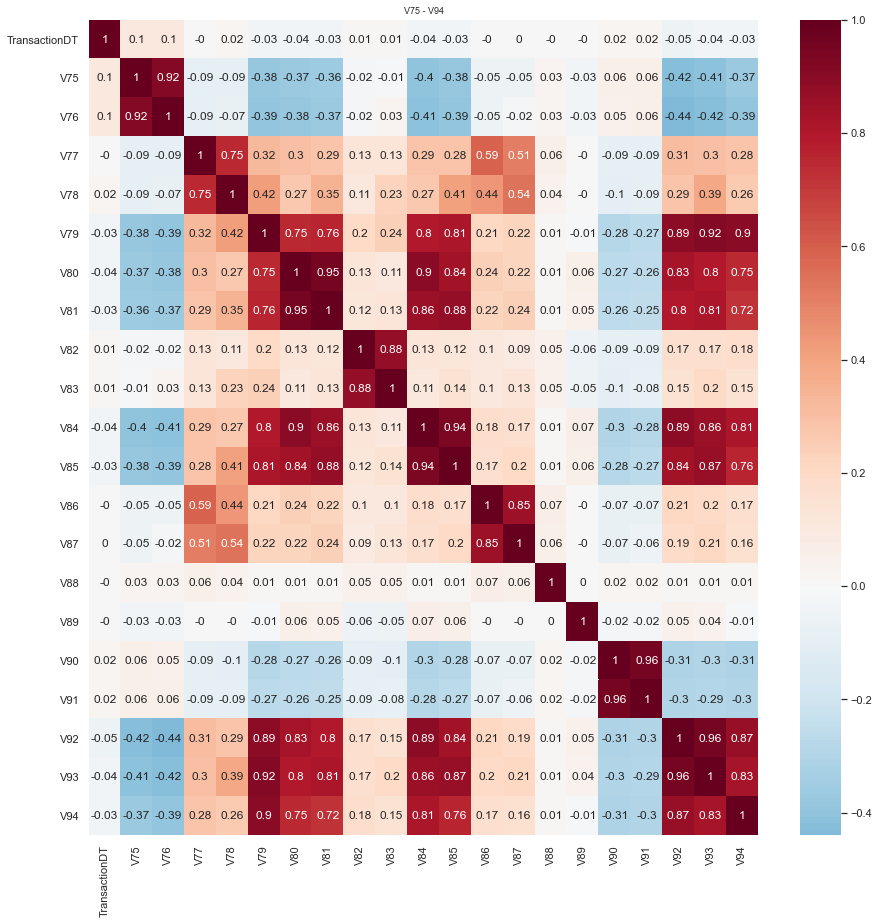

In [39]:
Vs = nans_groups[89164]
make_plots(Vs)
make_corr(Vs)

In [40]:
grps = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[88],[89],[90,91]]
reduce_group(grps)

Use these [76, 78, 80, 82, 86, 88, 89, 91]


### V95 - V137

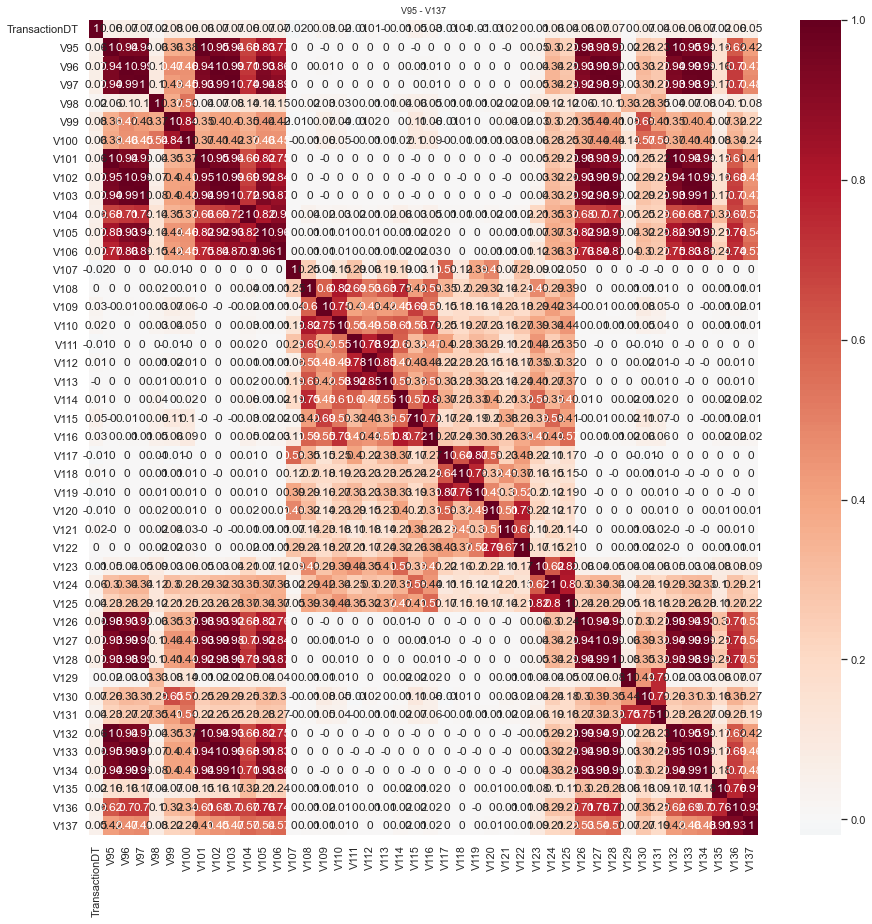

In [41]:
Vs = nans_groups[314]
make_corr(Vs)

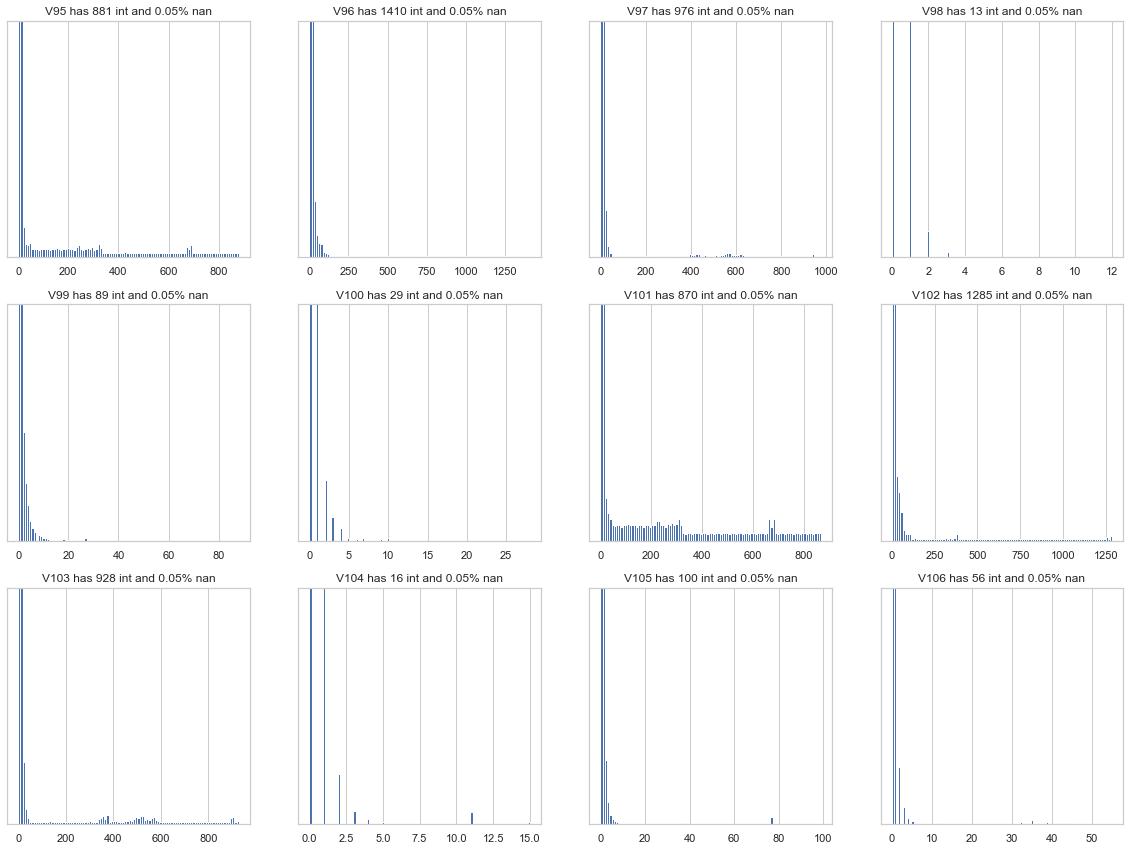

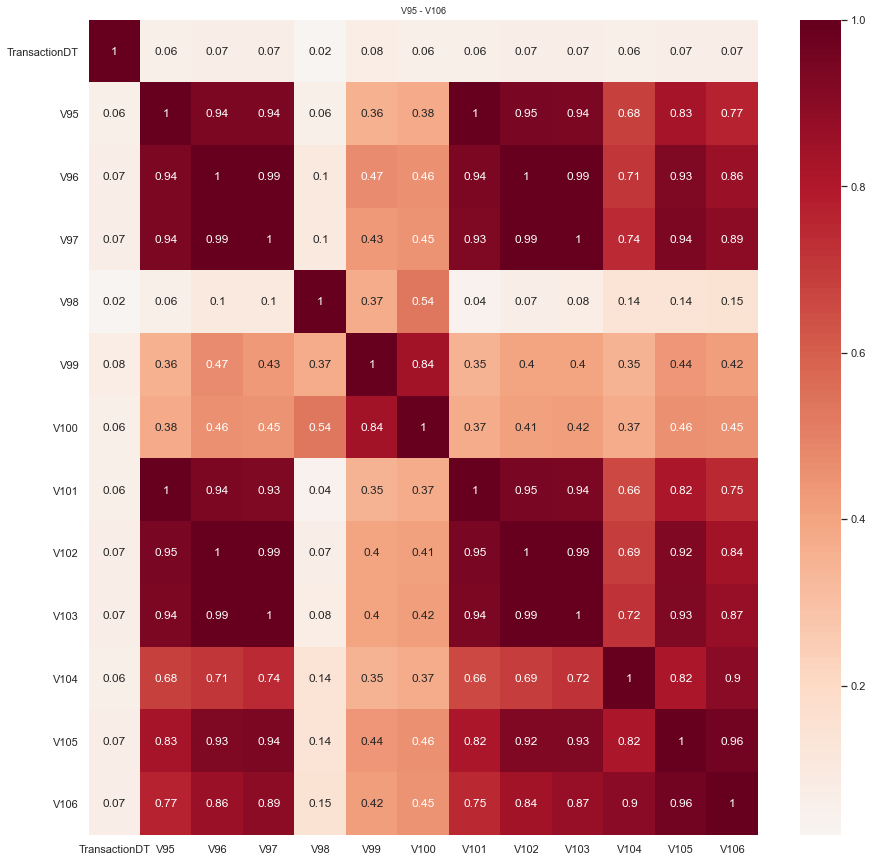

In [42]:
Vs = ['V'+str(x) for x in range(95,107)]
make_plots(Vs)
make_corr(Vs)

In [43]:
grps = [[95,96,97,101,102,103,105,106],[98],[99,100],[104]]
reduce_group(grps)

Use these [96, 98, 99, 104]


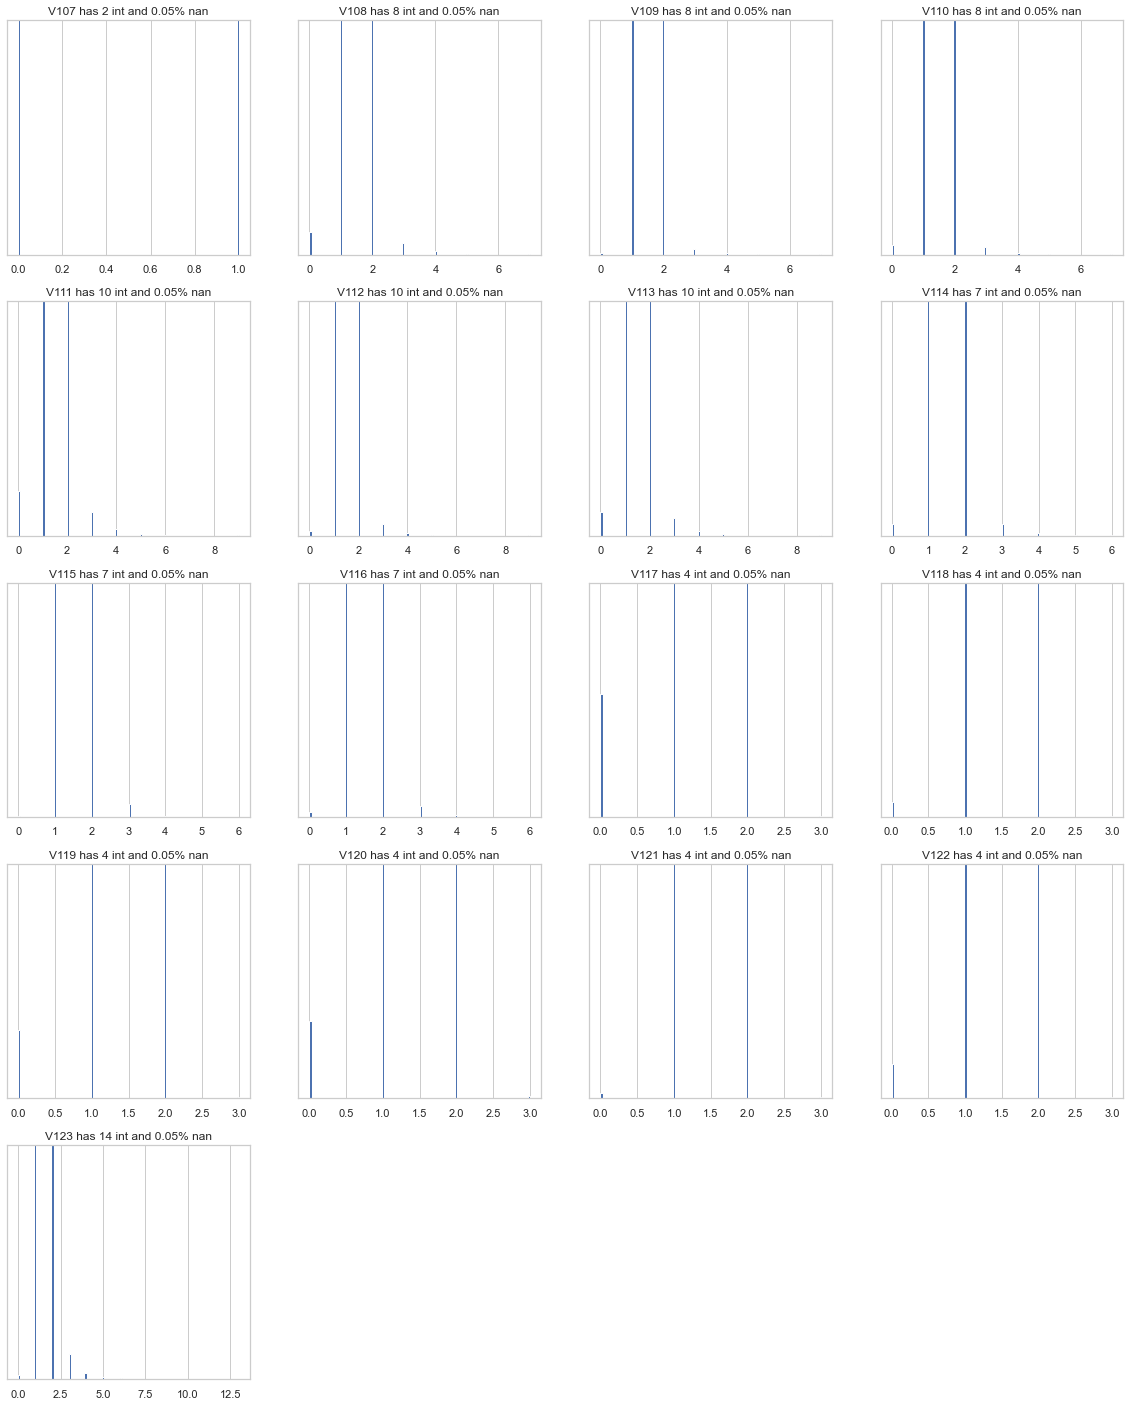

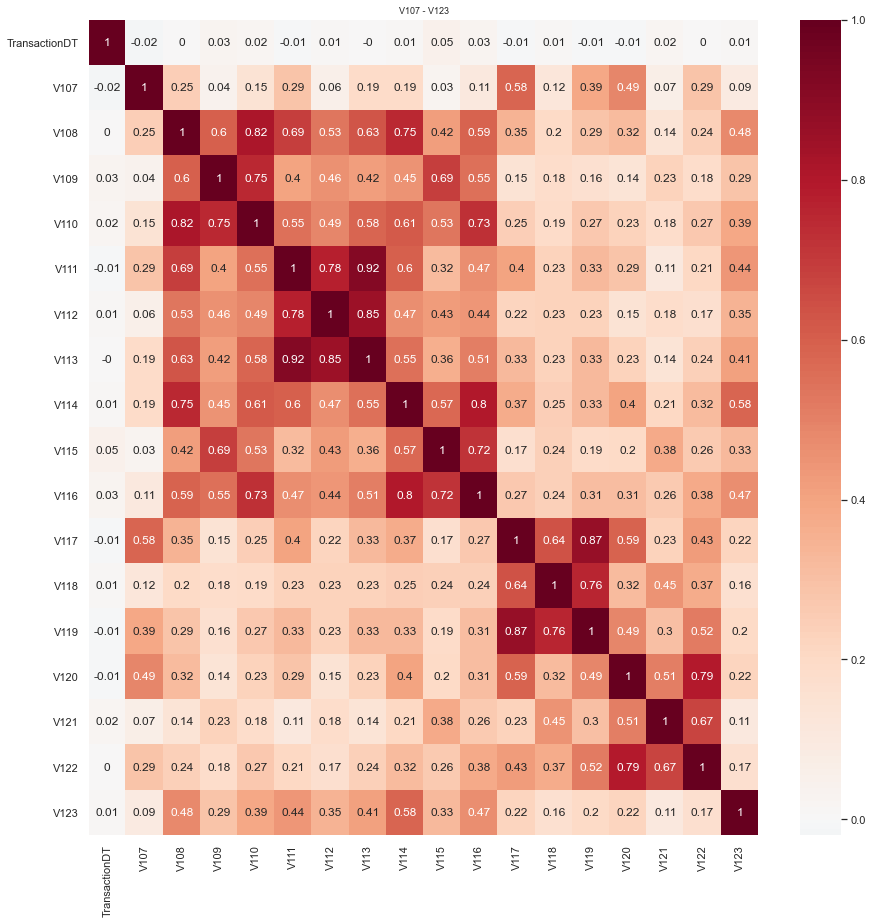

In [44]:
Vs = ['V'+str(x) for x in range(107,124)]
make_plots(Vs)
make_corr(Vs)

In [45]:
grps = [[107],[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123]]
reduce_group(grps)

Use these [107, 108, 111, 115, 117, 120, 121, 123]


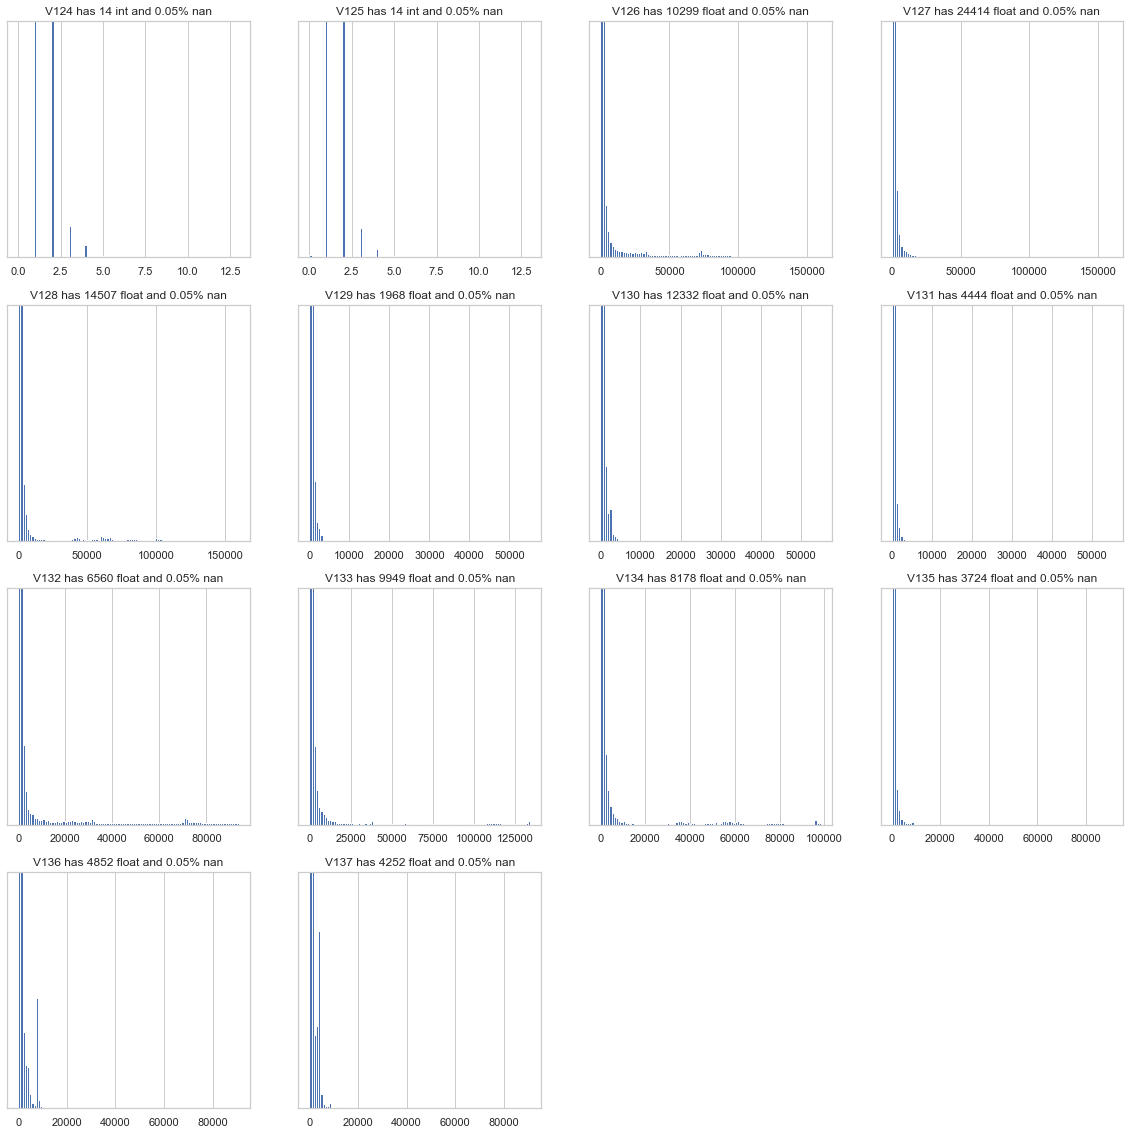

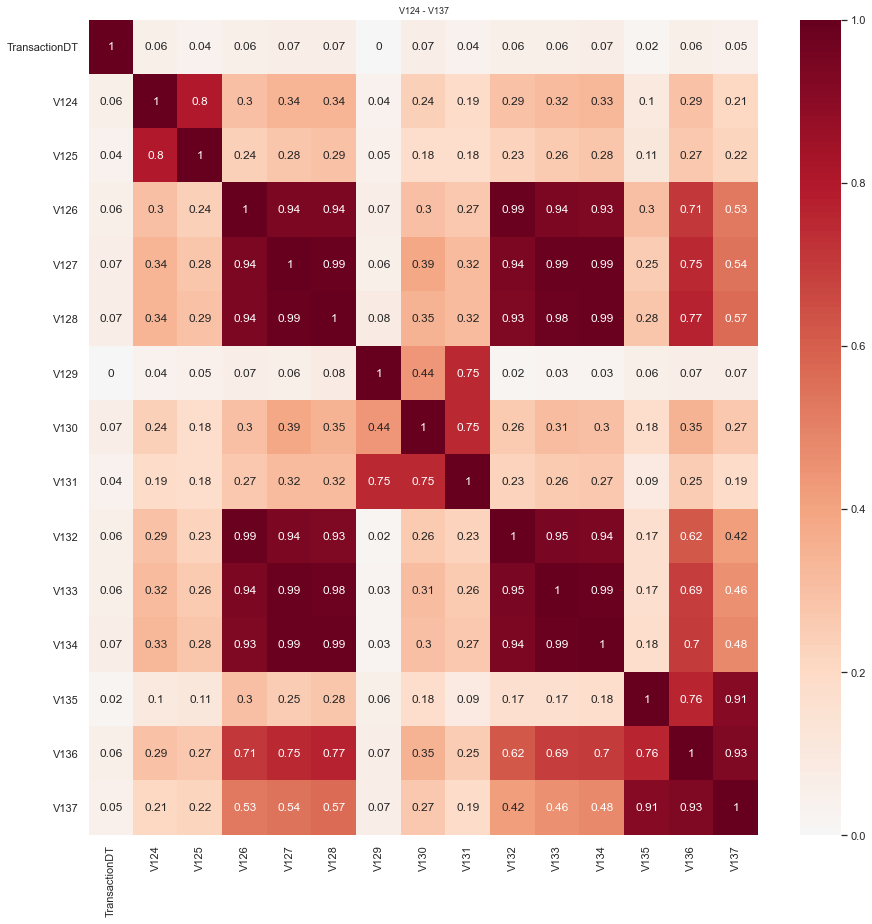

In [46]:
Vs = ['V'+str(x) for x in range(124,138)]
make_plots(Vs)
make_corr(Vs)

In [47]:
grps = [[124,125],[126,127,128,132,133,134],[129],[130,131],[135,136,137]]
reduce_group(grps)

Use these [124, 127, 129, 130, 136]


### V138 ~ V163

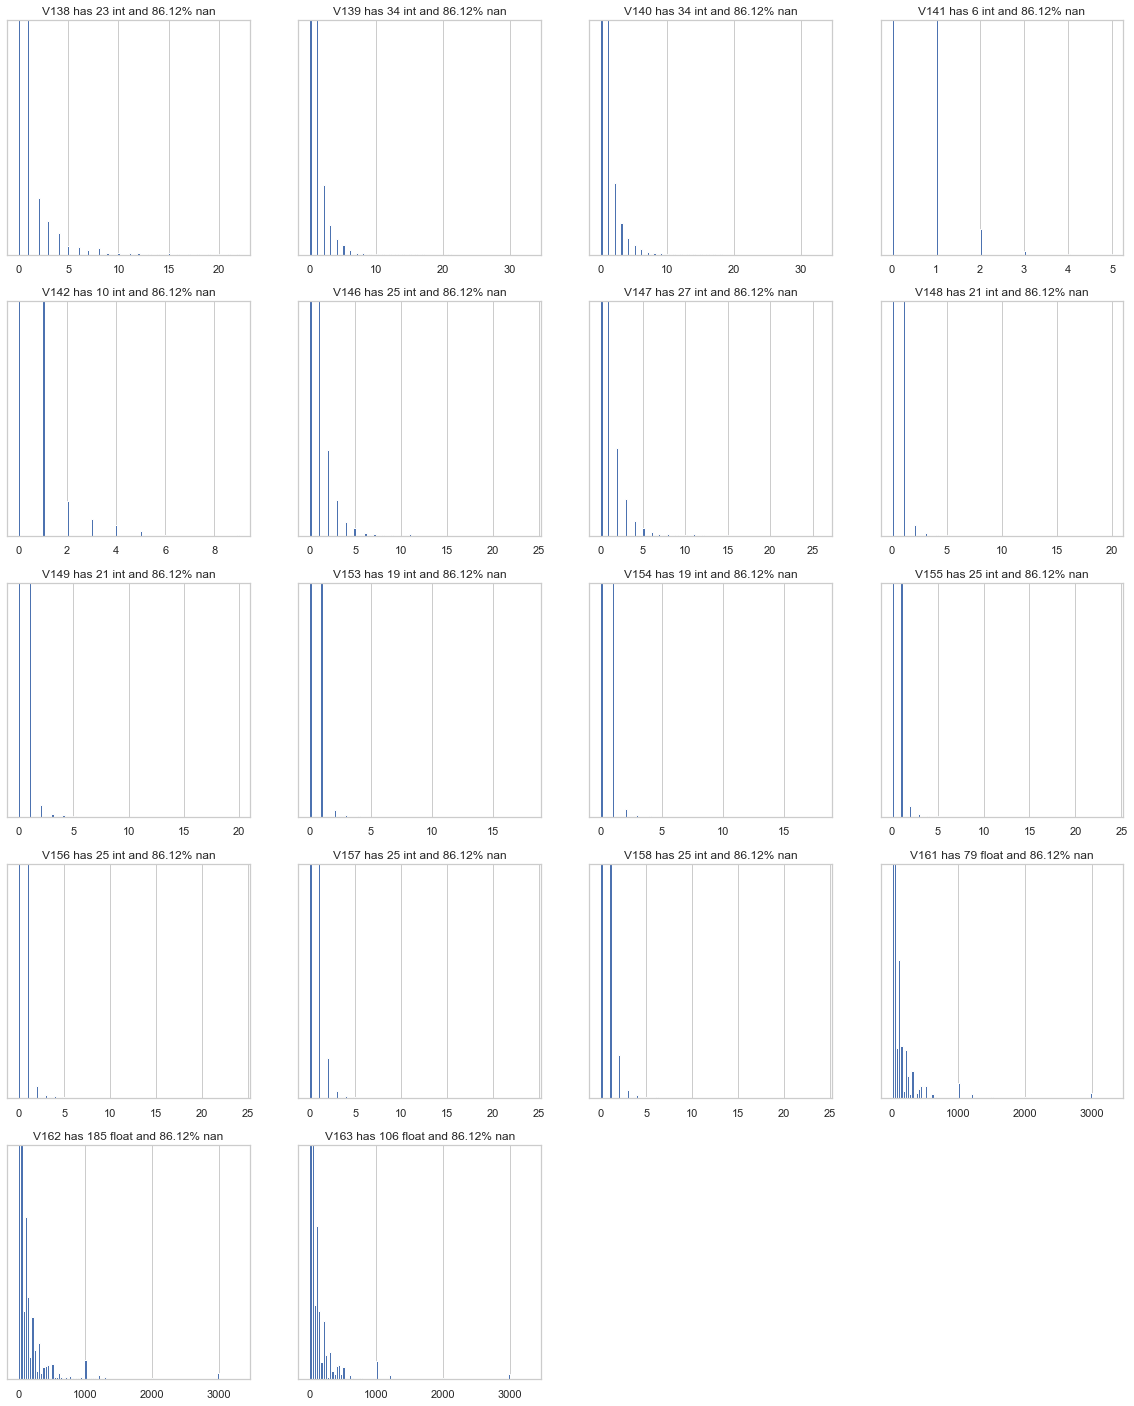

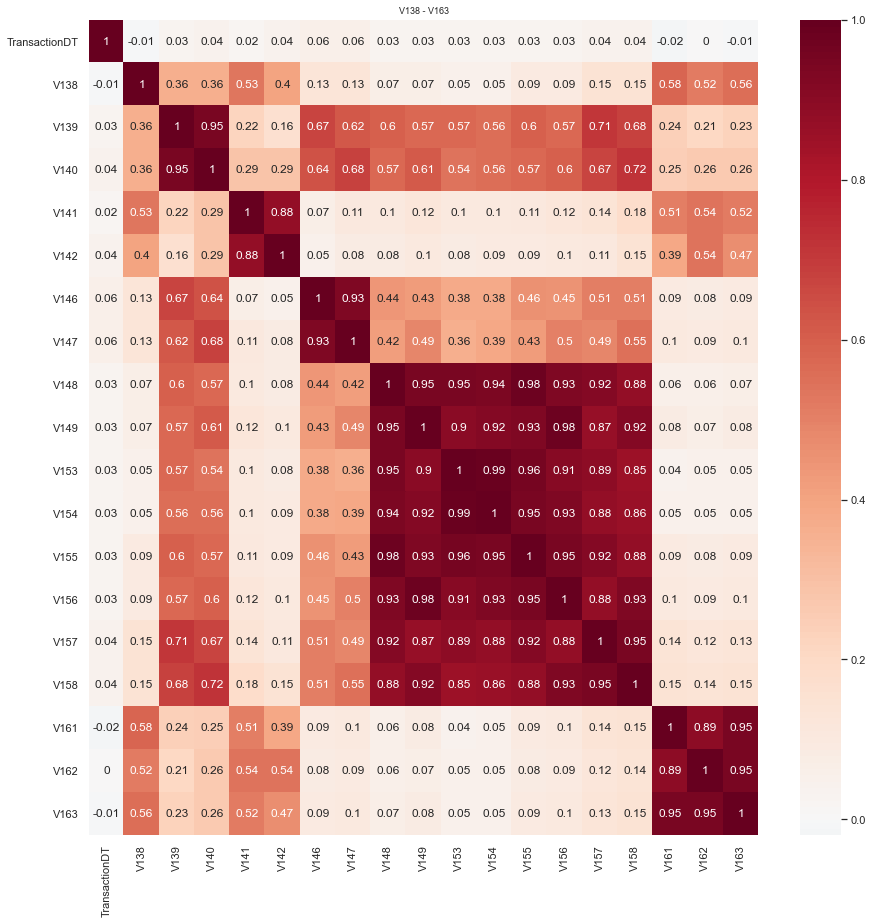

In [48]:
Vs = nans_groups[508595]
make_plots(Vs)
make_corr(Vs)

In [49]:
grps = [[138],[139,140],[141,142],[146,147],[148,149,153,154,156,157,158],[161,162,163]]
reduce_group(grps)

Use these [138, 139, 142, 147, 156, 162]


### V143 ~ V166

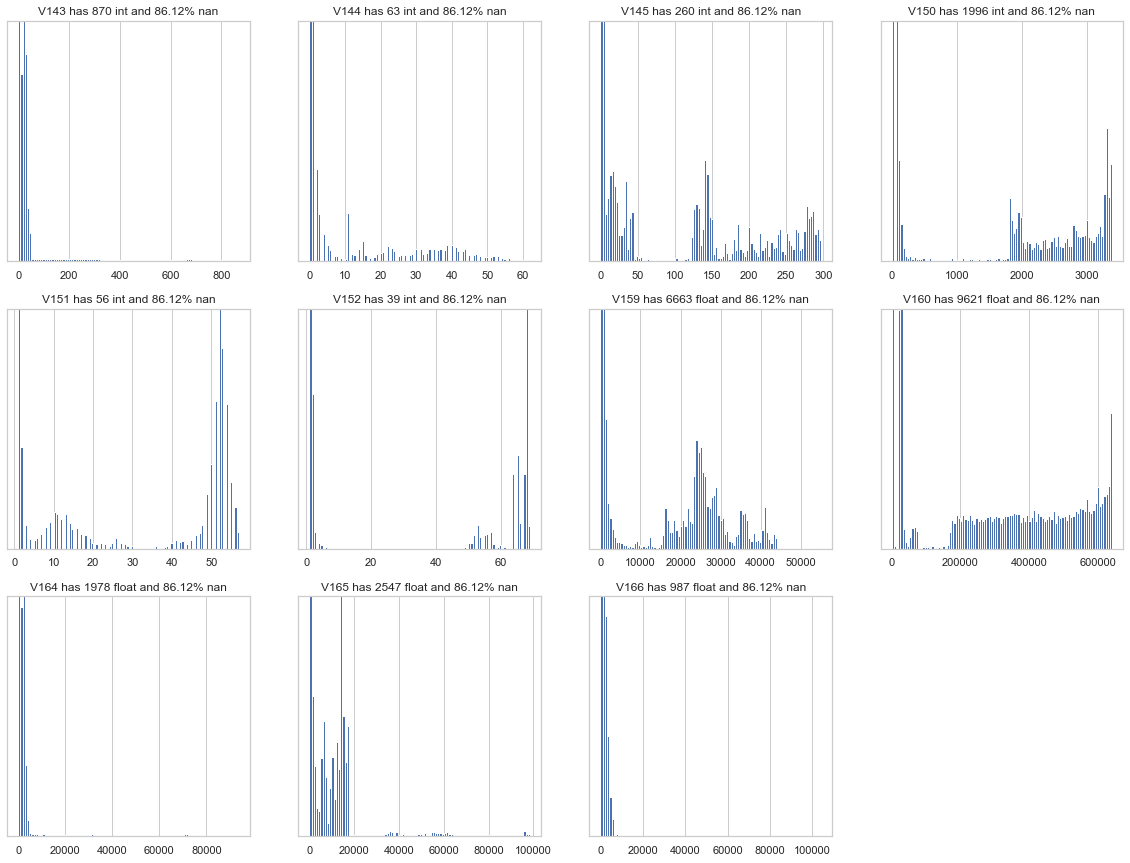

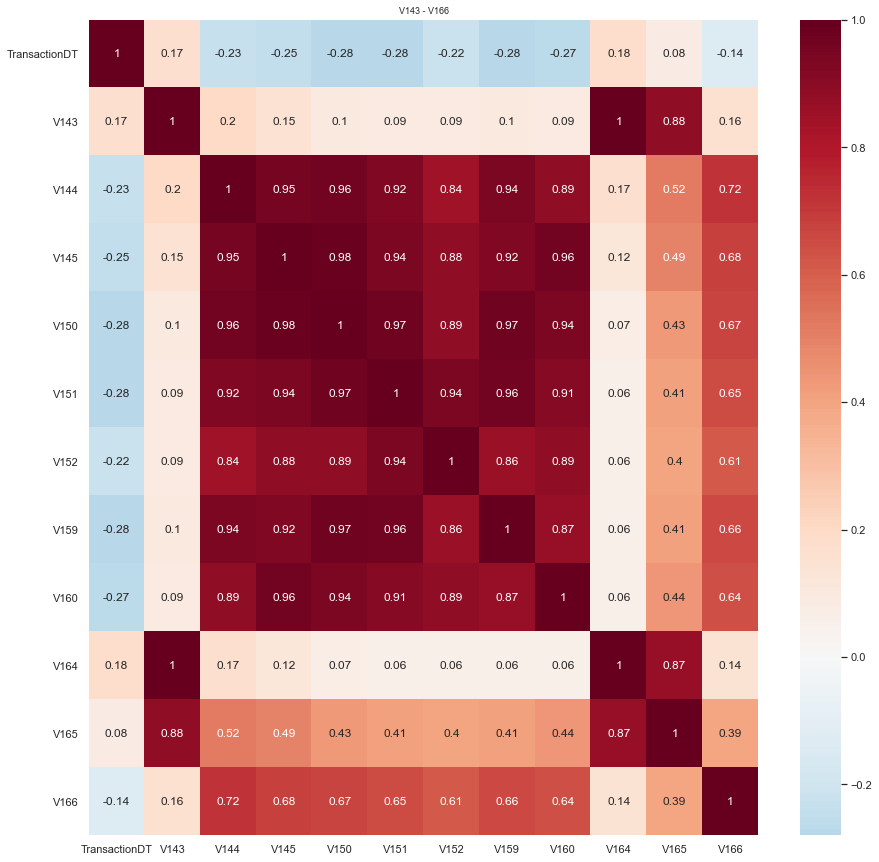

In [50]:
Vs = nans_groups[508589]
make_plots(Vs)
make_corr(Vs)

In [51]:
grps = [[143,164,165],[144,145,150,151,152,159,160],[166]]
reduce_group(grps)

Use these [165, 160, 166]


### V167 ~ V216

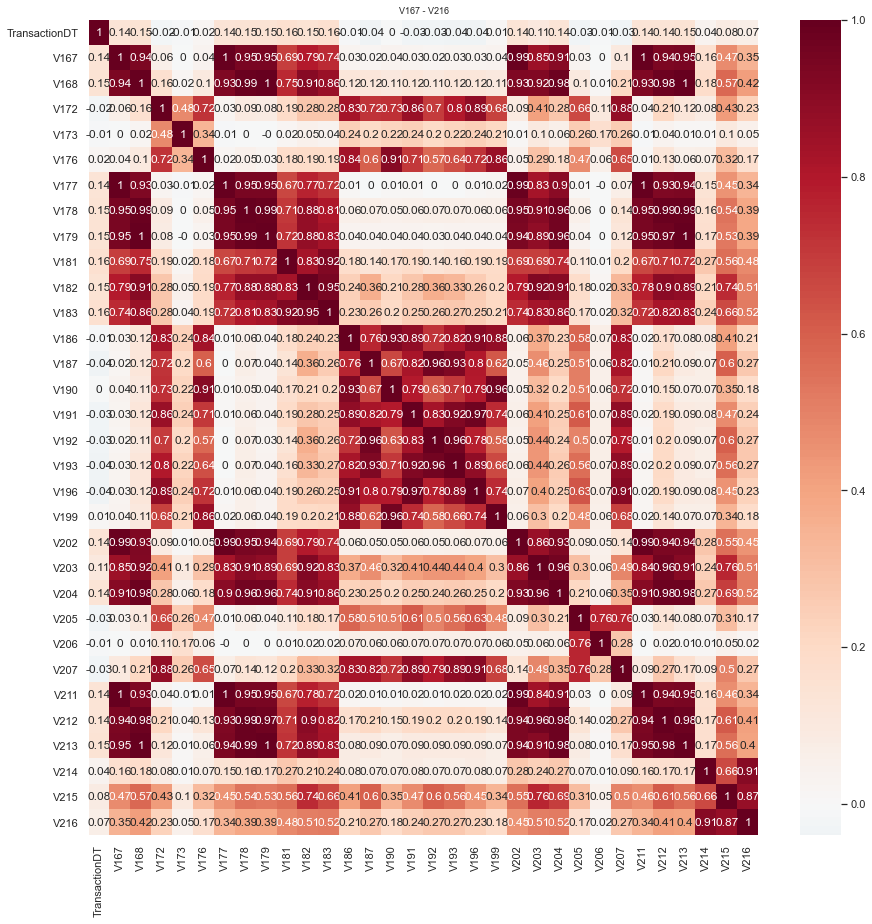

In [52]:
Vs = [x for x in nans_groups[450909]]
make_corr(Vs)

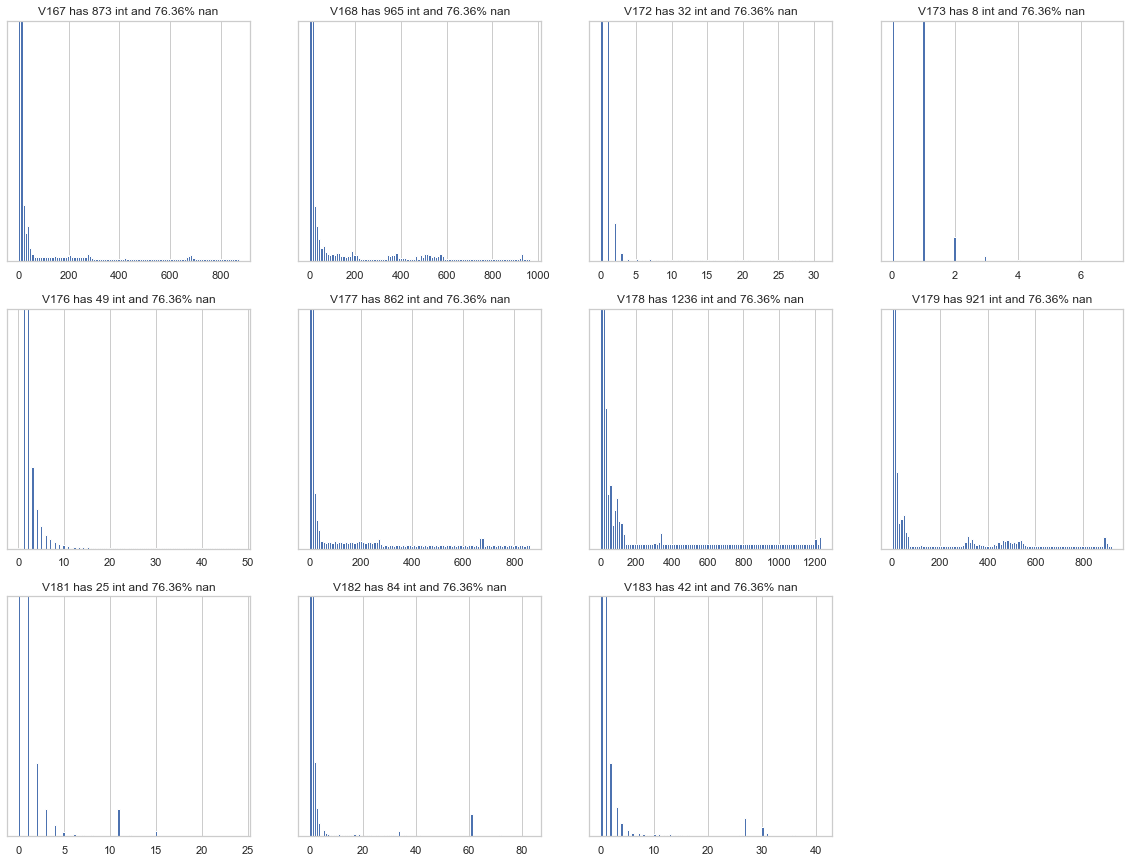

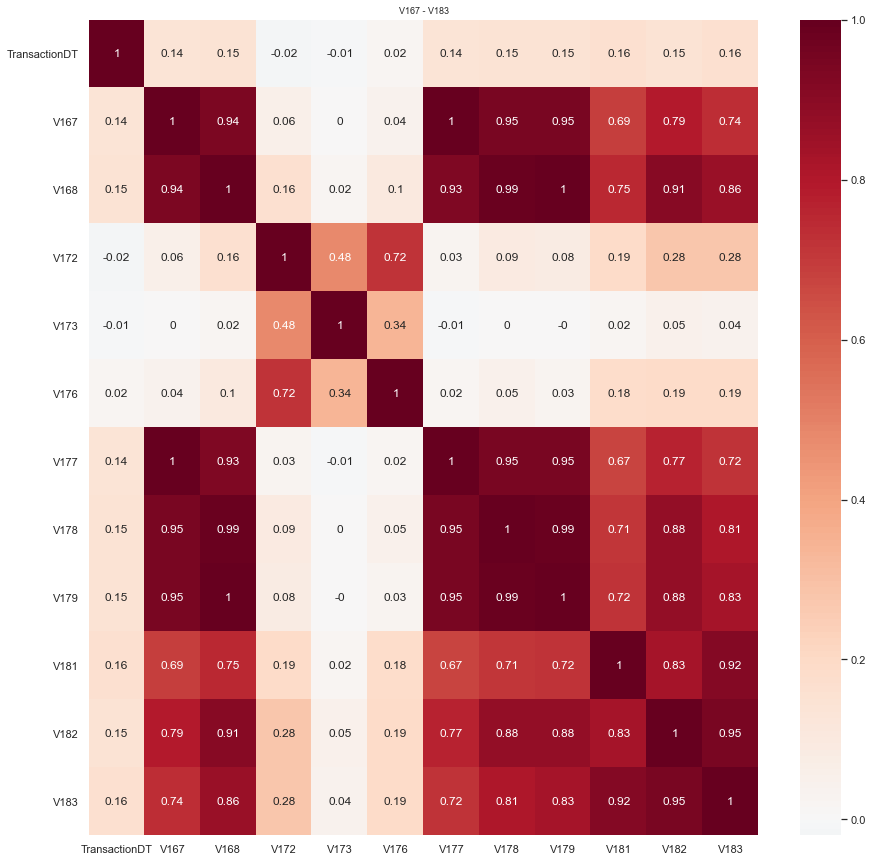

In [53]:
Vs = [x for x in nans_groups[450909] if int(x[1:])<186]
make_plots(Vs)
make_corr(Vs)

In [54]:
grps = [[167,168,177,178,179],[172,176],[173],[181,182,183]]
reduce_group(grps)

Use these [178, 176, 173, 182]


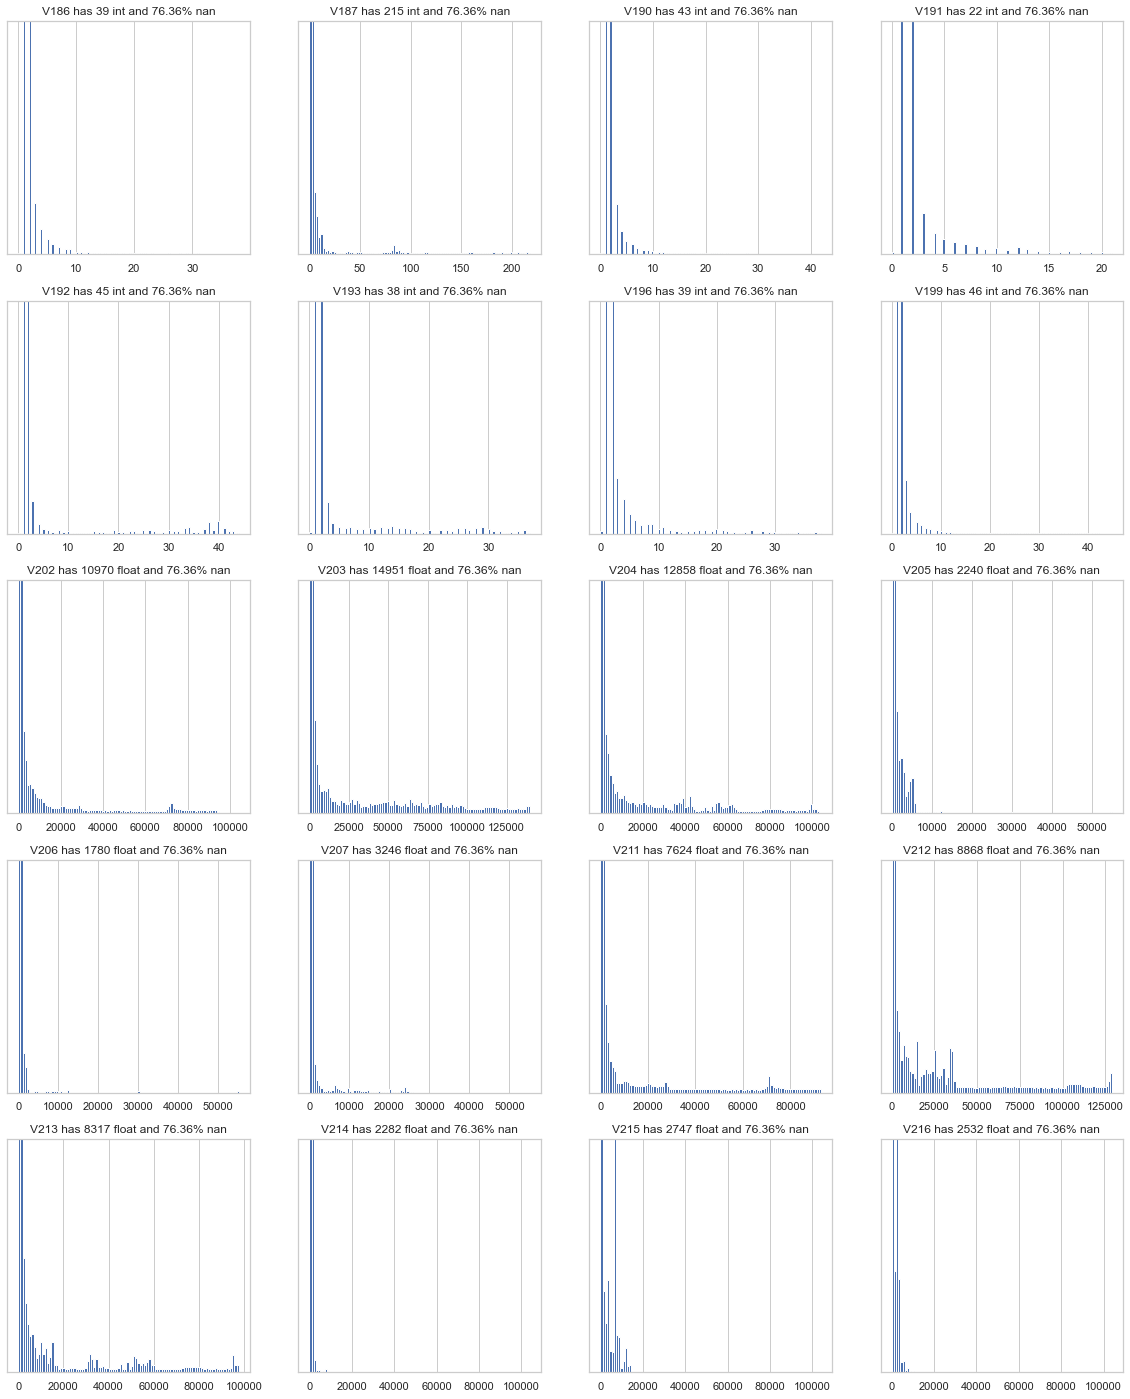

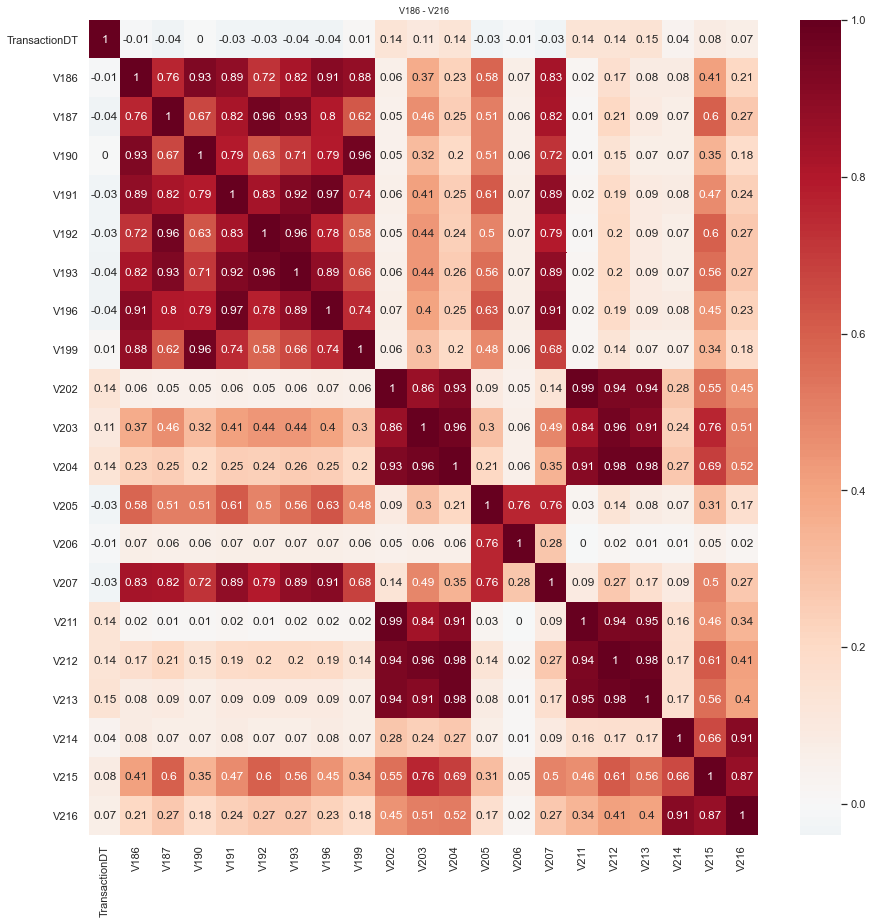

In [55]:
Vs = [x for x in nans_groups[450909] if (int(x[1:])>183)]
make_plots(Vs)
make_corr(Vs)

In [56]:
grps = [[186,187,190,191,192,193,196,199],[202,203,204,211,212,213],[205,206],[207],[214,215,216]]
reduce_group(grps)

Use these [187, 203, 205, 207, 215]


### V169 ~ V210

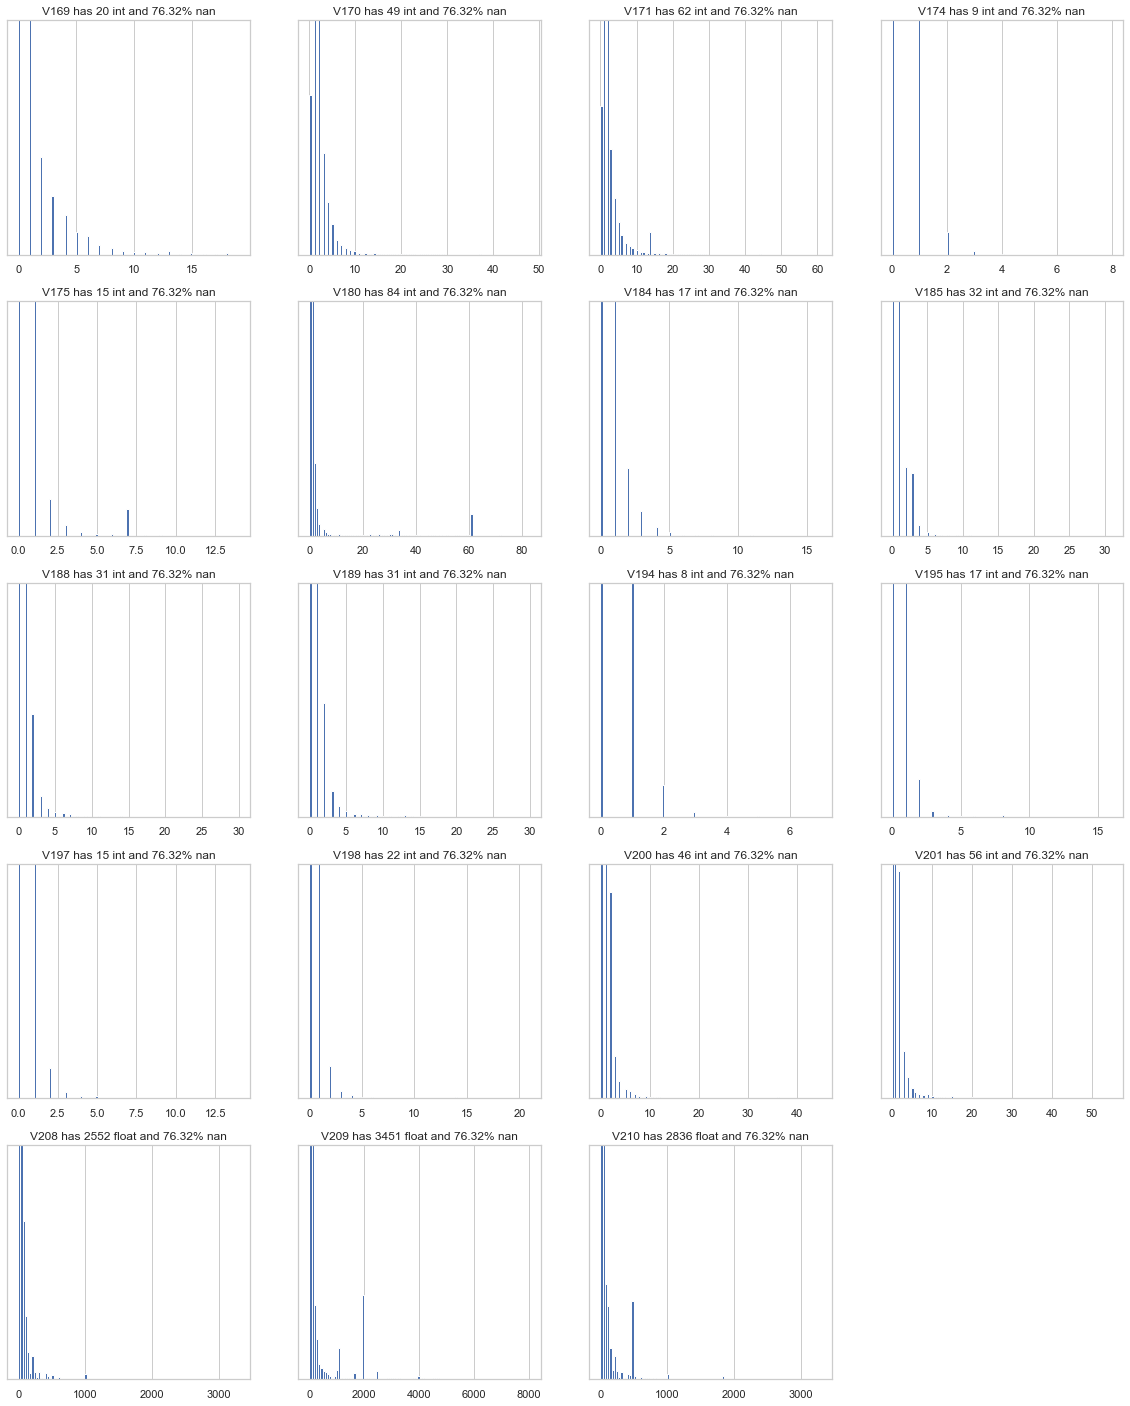

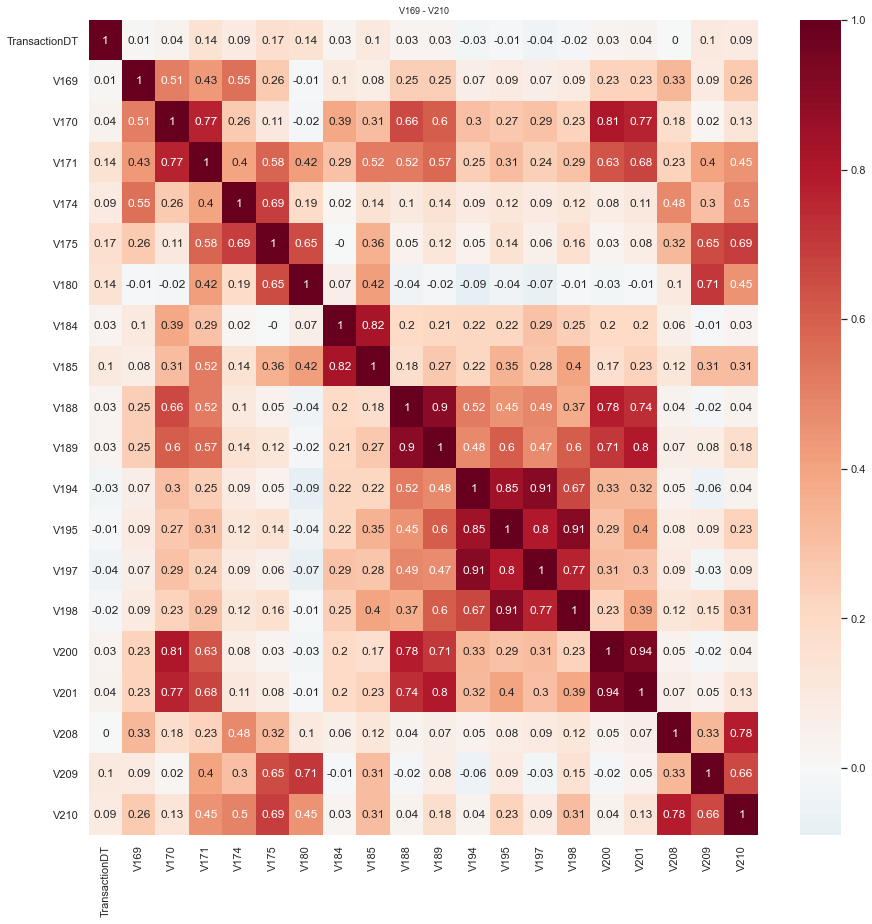

In [57]:
Vs = nans_groups[450721]
make_plots(Vs)
make_corr(Vs)

In [58]:
grps = [[169],[170,171,200,201],[174,175],[180],[184,185],[188,189],[194,195,197,198],[208,210],[209]]
reduce_group(grps)

Use these [169, 171, 175, 180, 185, 188, 198, 210, 209]


### V217 ~ V278

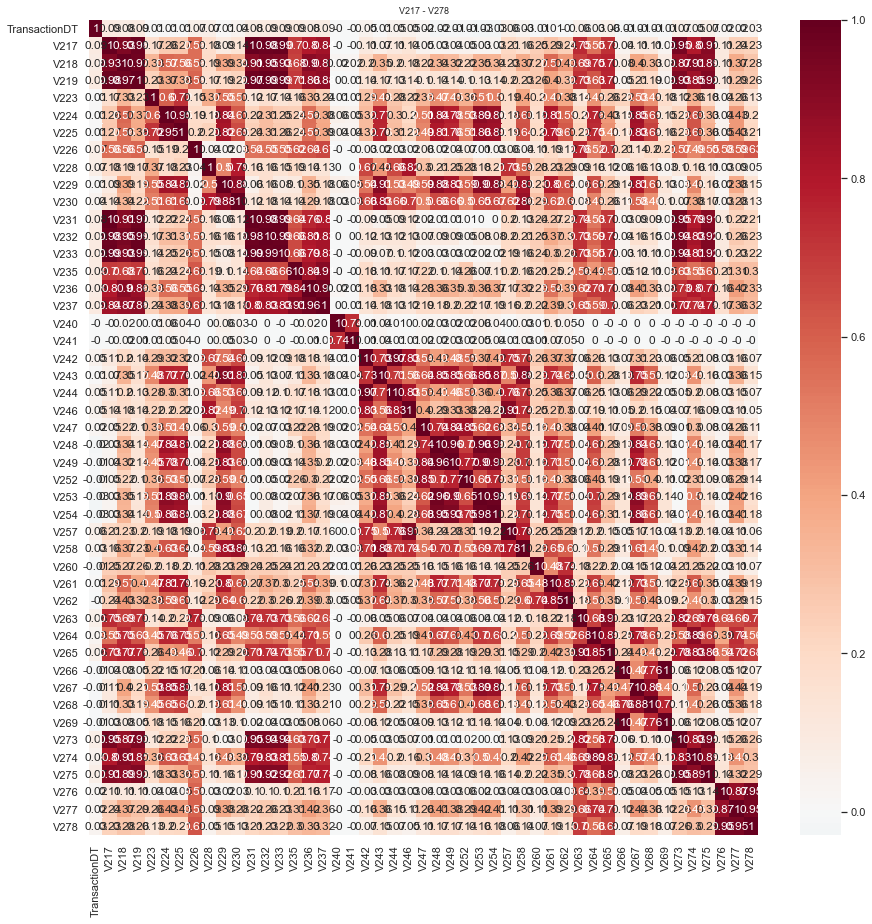

In [59]:
Vs = [x for x in nans_groups[460110]]
make_corr(Vs)

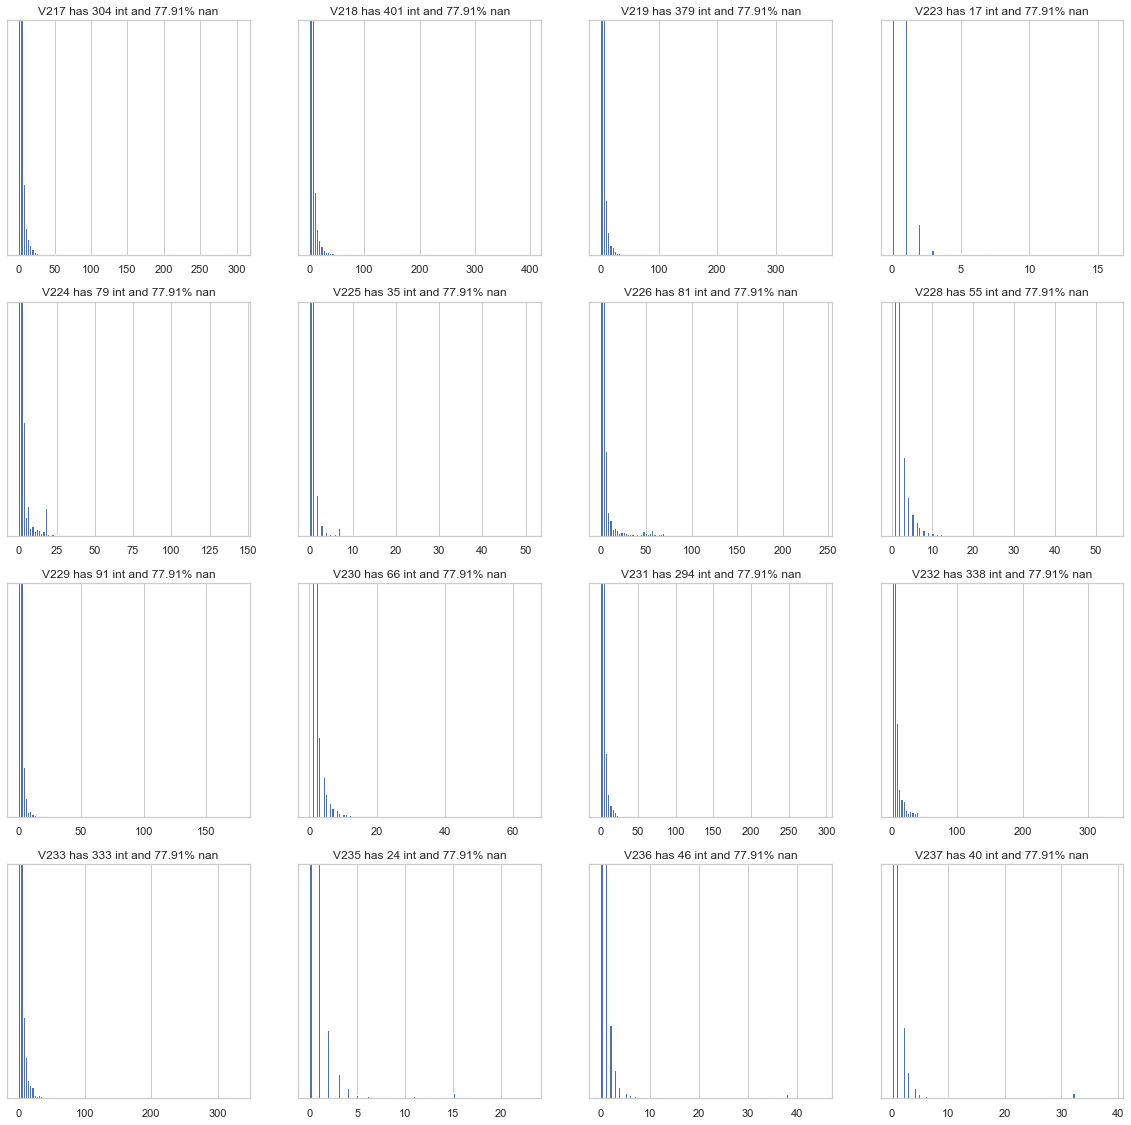

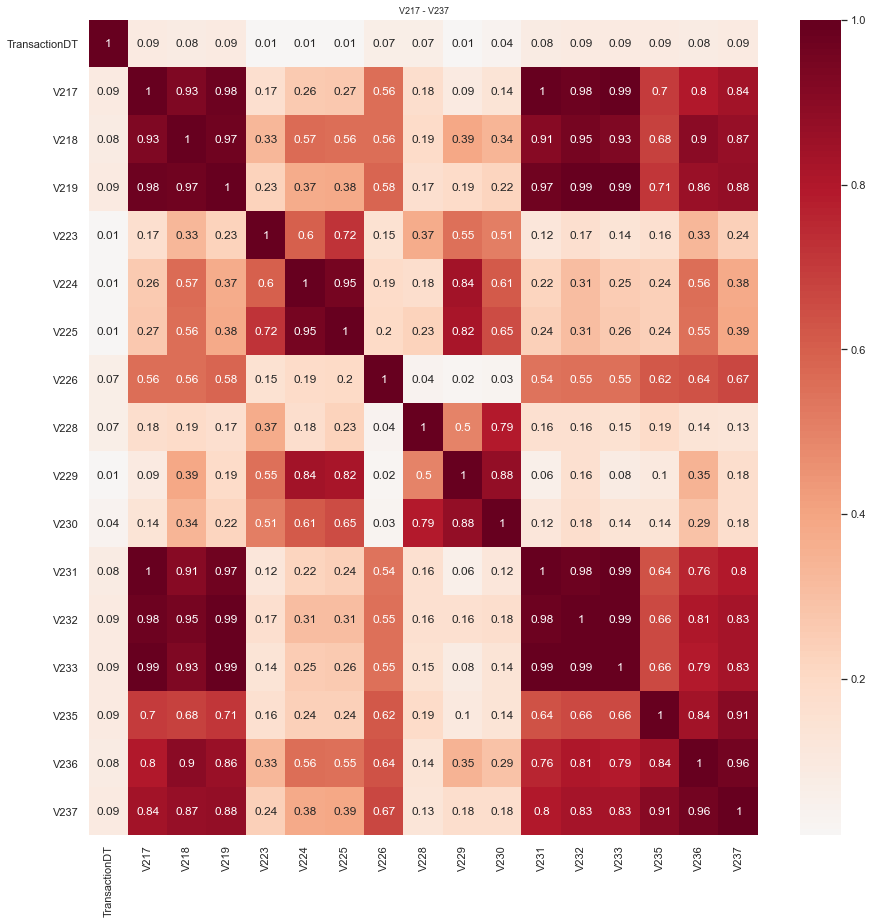

In [60]:
Vs = [x for x in nans_groups[460110] if int(x[1:])<240]
make_plots(Vs)
make_corr(Vs)

In [61]:
grps = [[217,218,219,231,232,233,236,237],[223],[224,225],[226],[228],[229,230],[235]]
reduce_group(grps)

Use these [218, 223, 224, 226, 228, 229, 235]


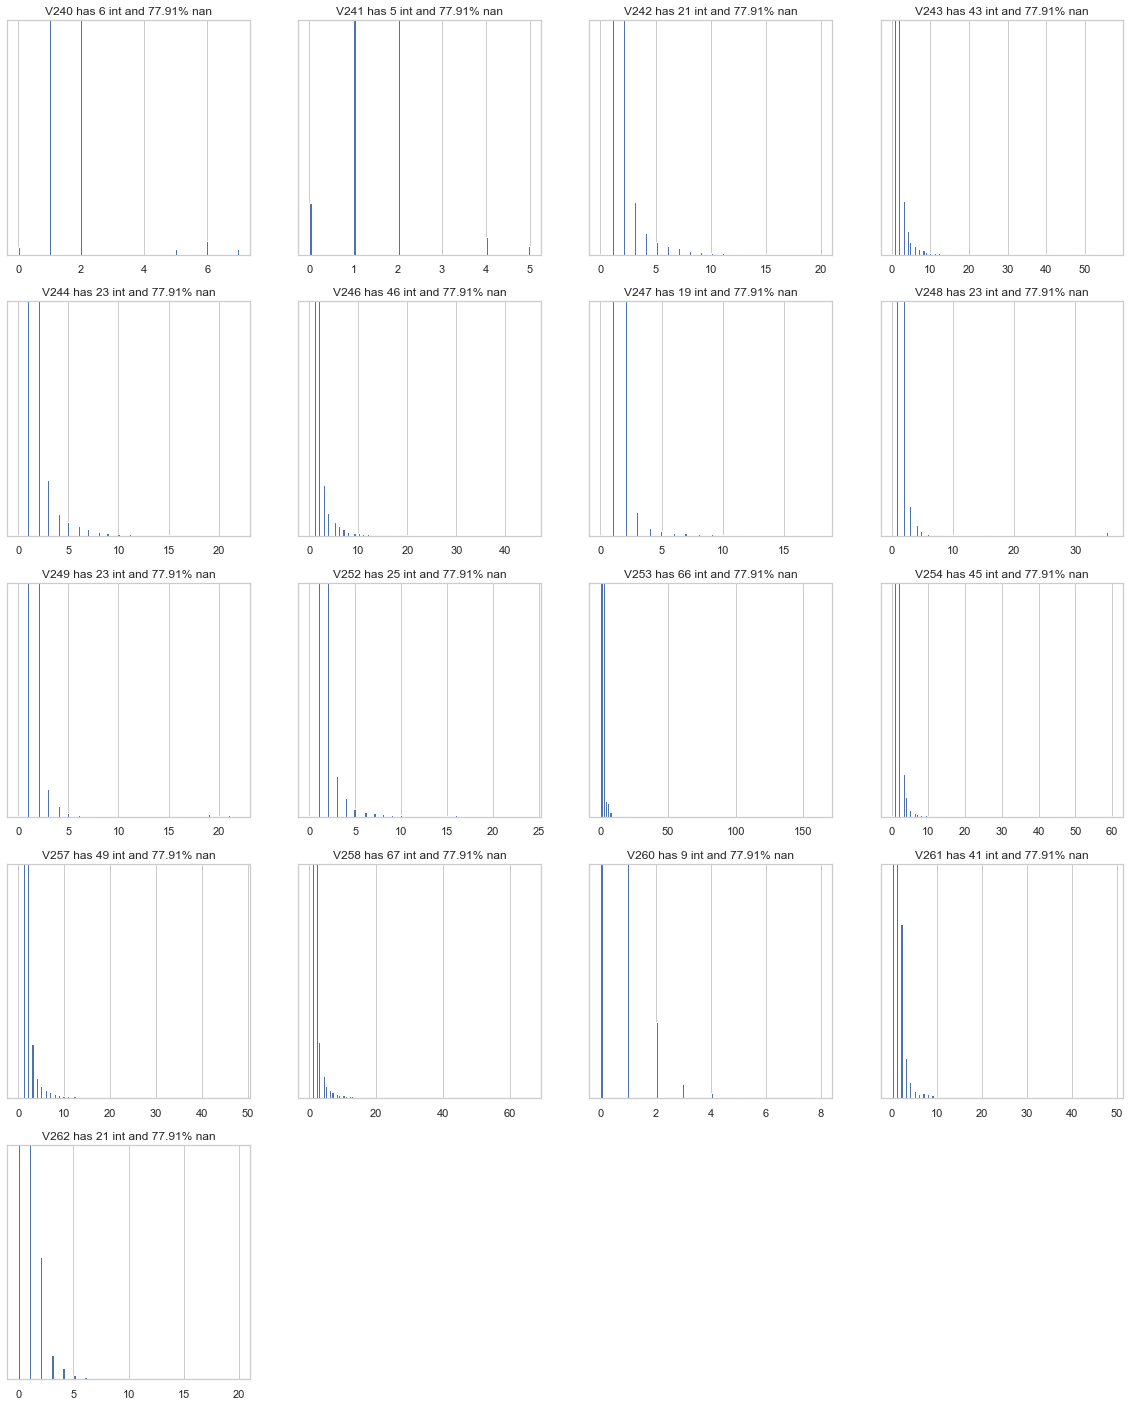

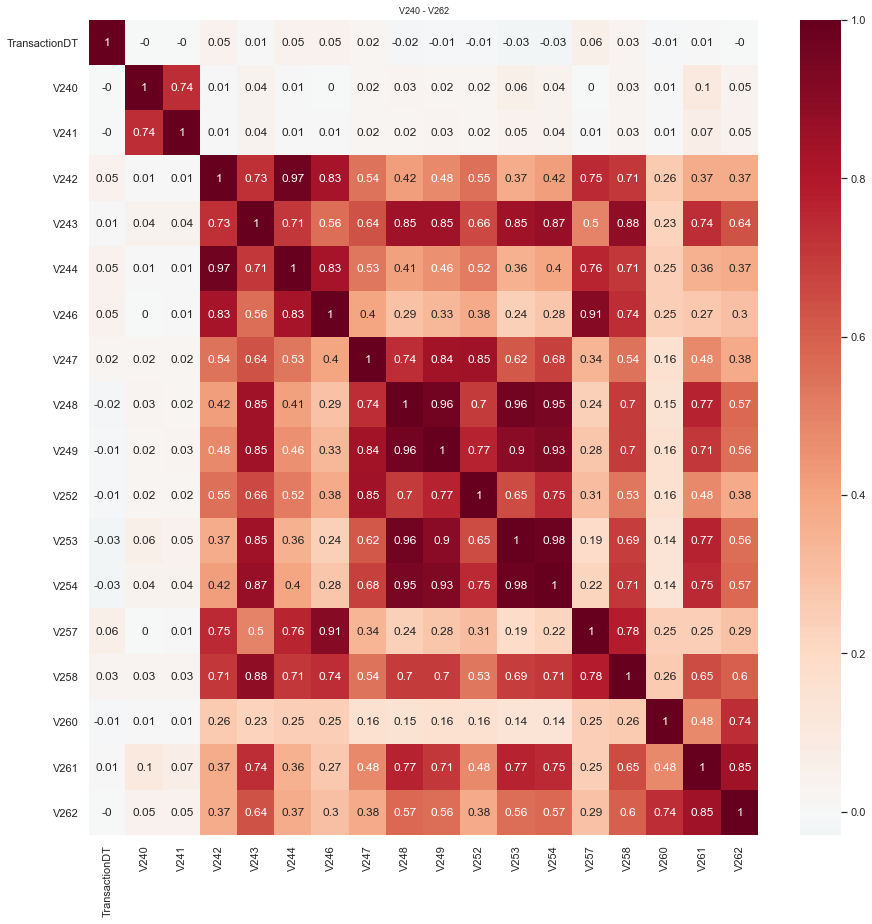

In [62]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>237)&(int(x[1:])<263)]
make_plots(Vs)
make_corr(Vs)

In [63]:
grps = [[240,241],[242,243,244,258],[246,257],[247,248,249,253,254],[252],[260],[261,262]]
reduce_group(grps)

Use these [240, 258, 257, 253, 252, 260, 261]


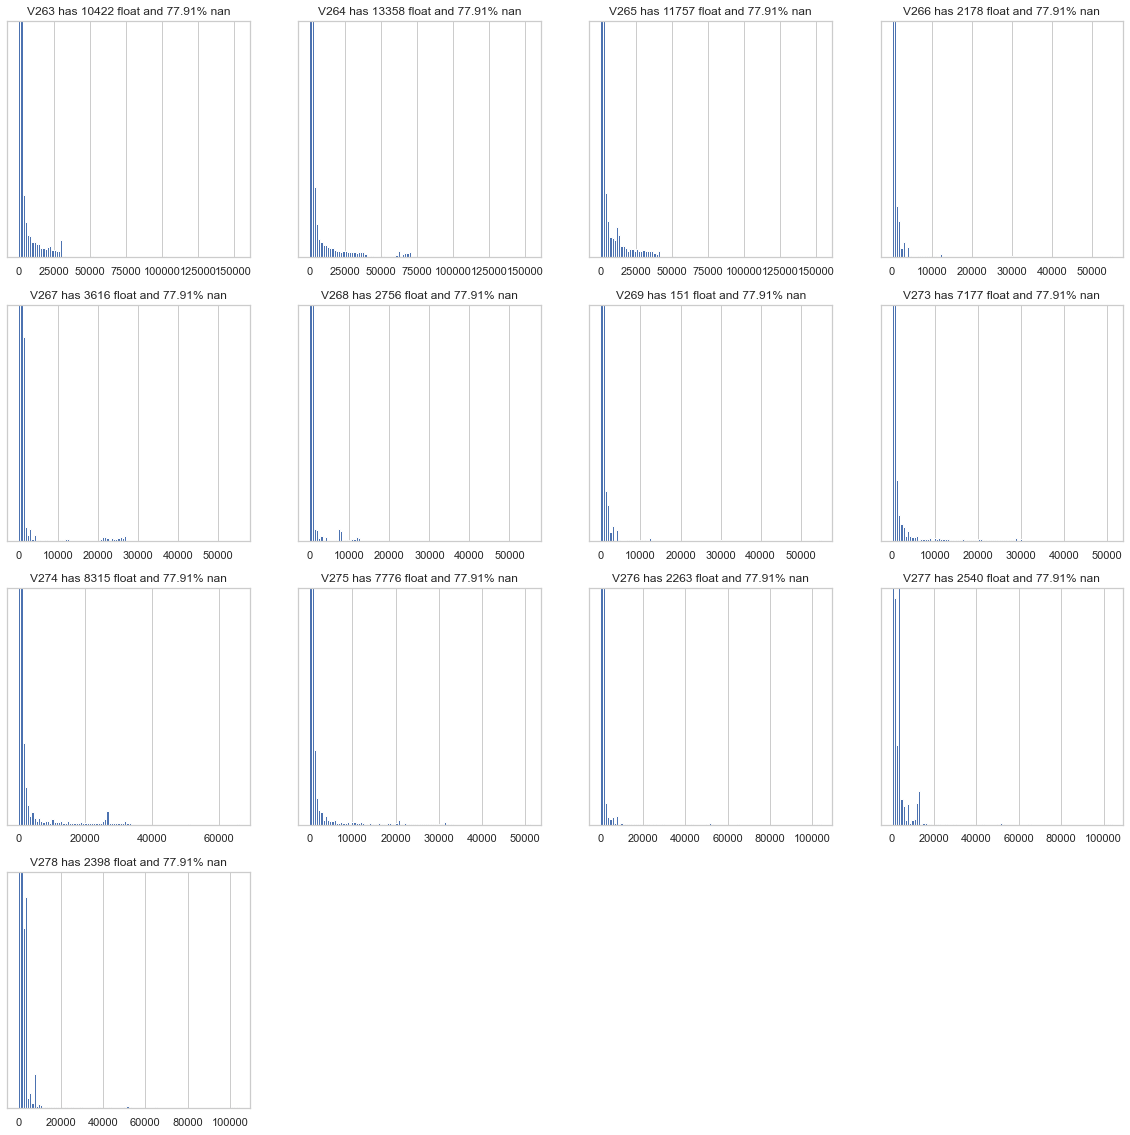

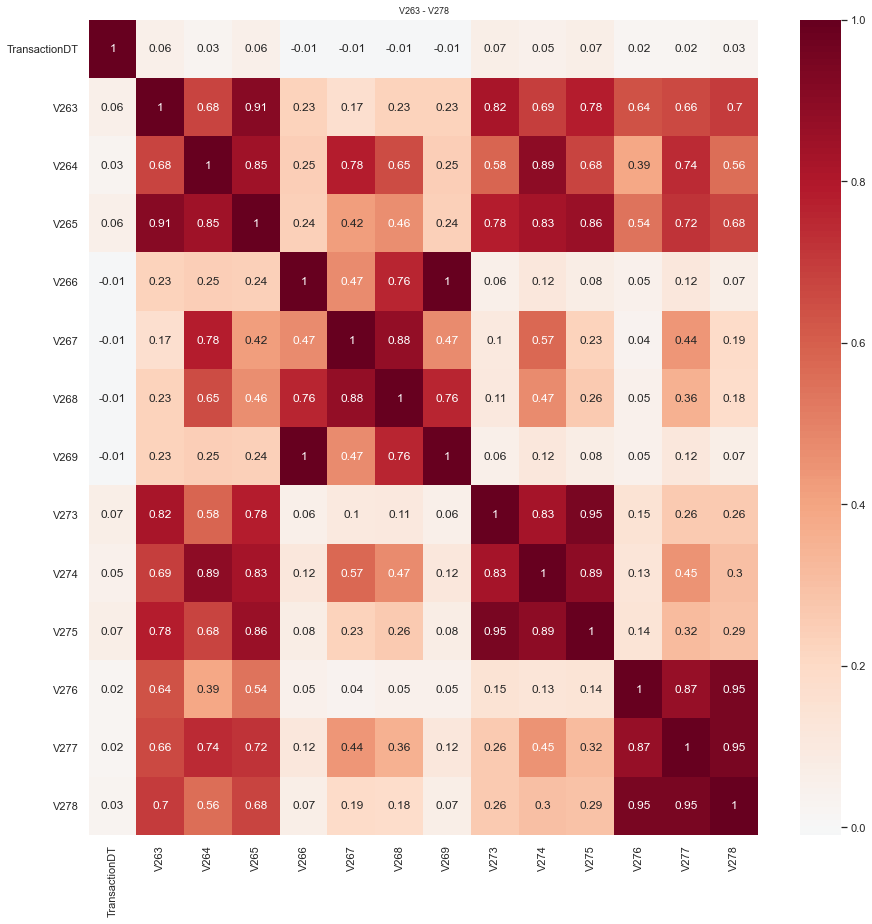

In [64]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>262)]
make_plots(Vs)
make_corr(Vs)

In [65]:
grps = [[263,265,264],[266,269],[267,268],[273,274,275],[276,277,278]]
reduce_group(grps)

Use these [264, 266, 267, 274, 277]


### V220 ~ V272

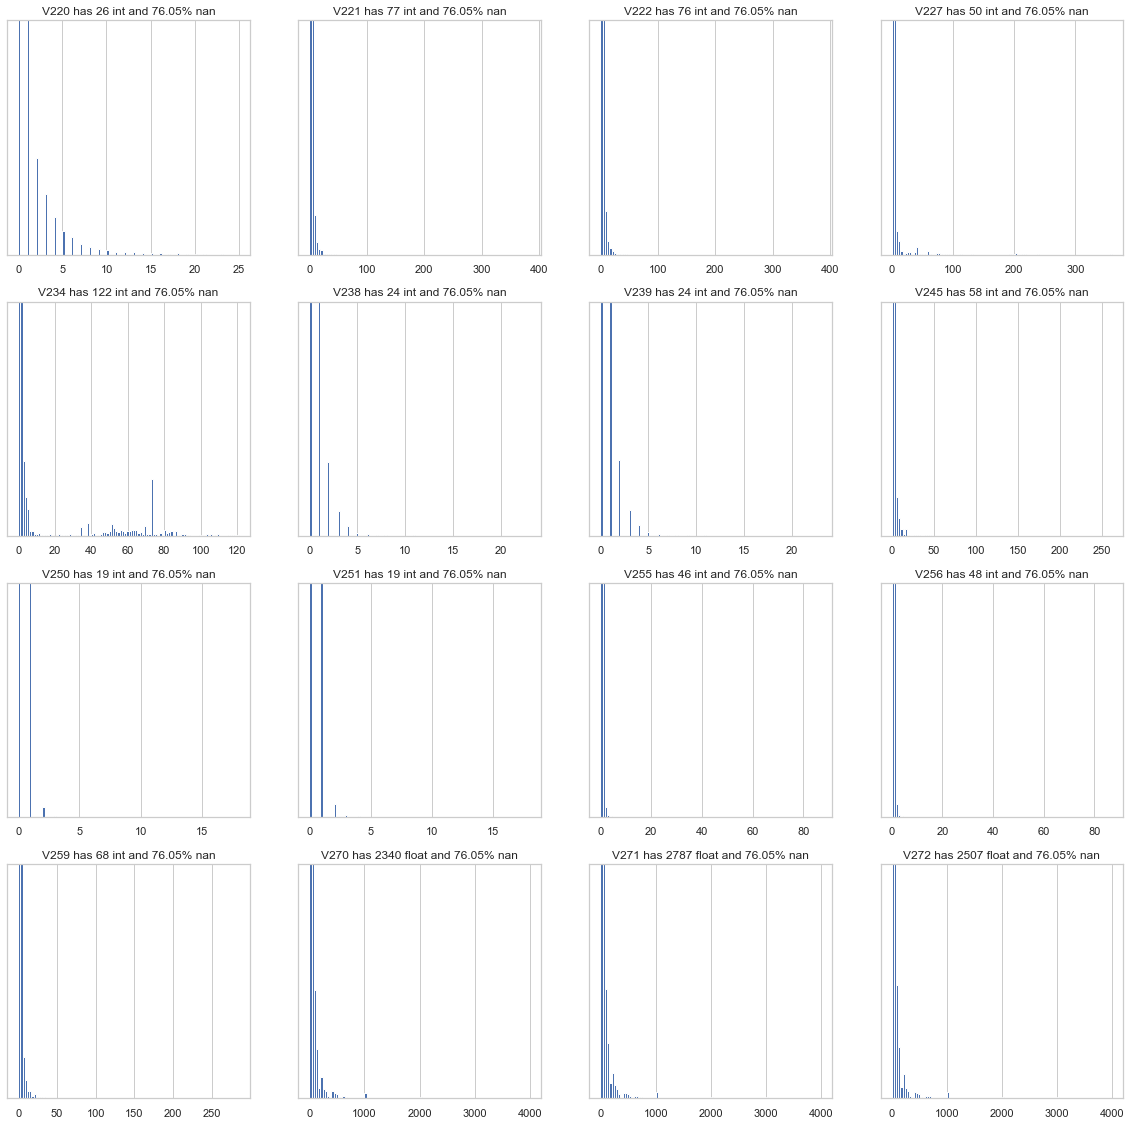

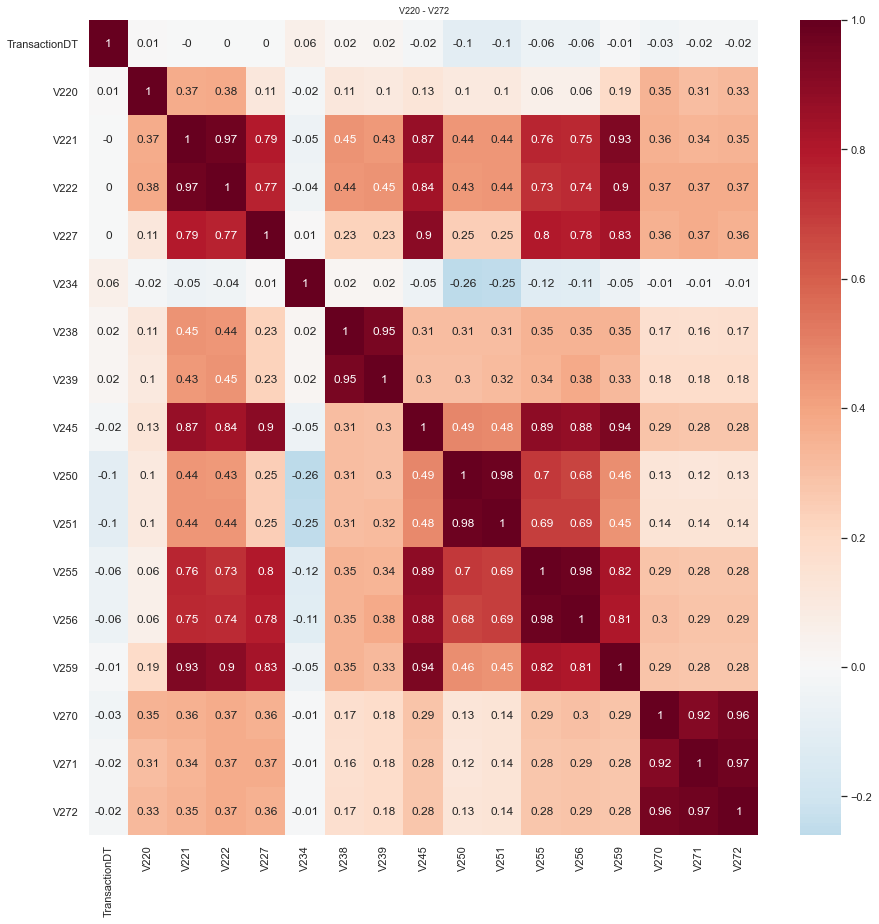

In [66]:
Vs = nans_groups[449124]
make_plots(Vs)
make_corr(Vs)

In [67]:
grps = [[220],[221,222,227,245,255,256,259],[234],[238,239],[250,251],[270,271,272]]
reduce_group(grps)

Use these [220, 221, 234, 238, 250, 271]


### V281 ~ V315, D1

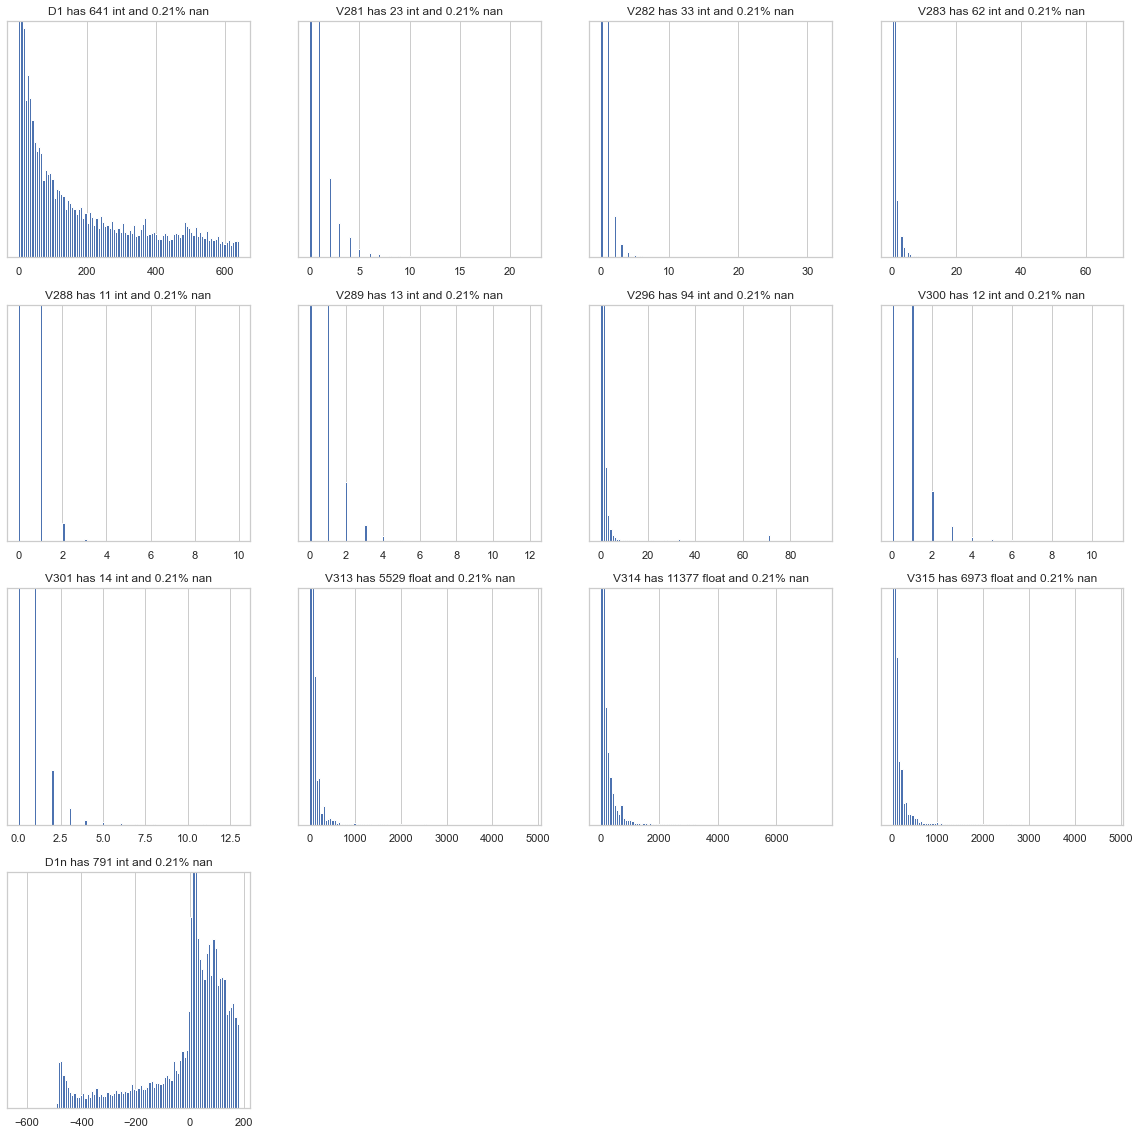

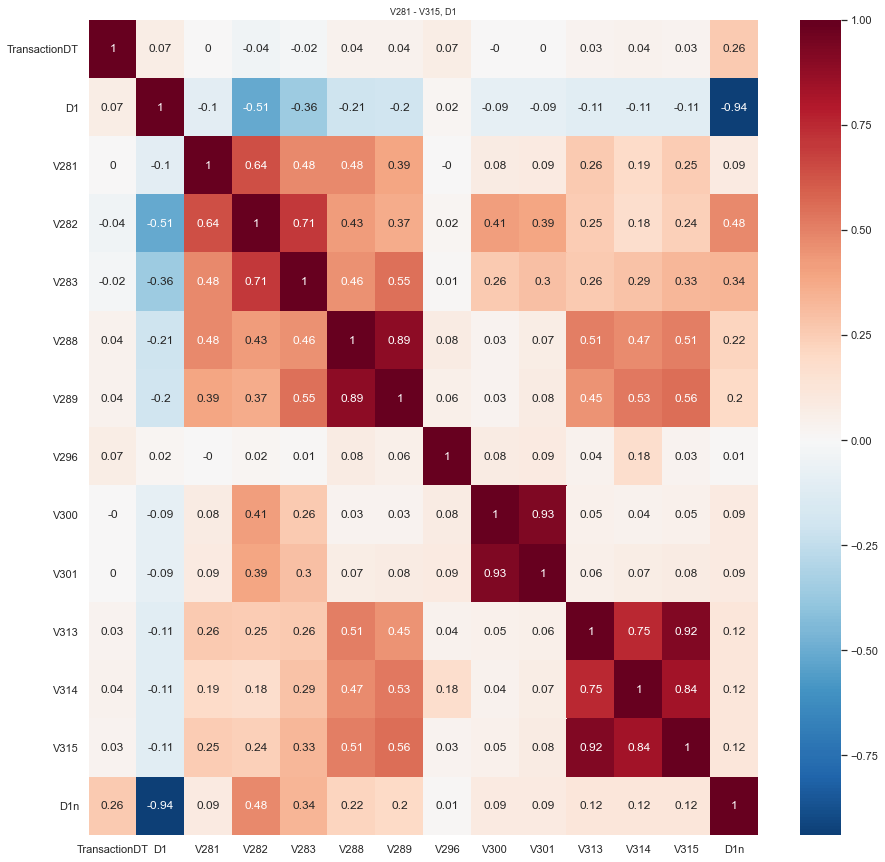

In [68]:
Vs = nans_groups[1269]
make_plots(Vs)
Vtitle = 'V281 - V315, D1'
make_corr(Vs,Vtitle)

In [69]:
grps = [[281],[282,283],[288,289],[296],[300,301],[313,314,315]]
reduce_group(grps)

Use these [281, 283, 289, 296, 301, 314]


### V322 - V339

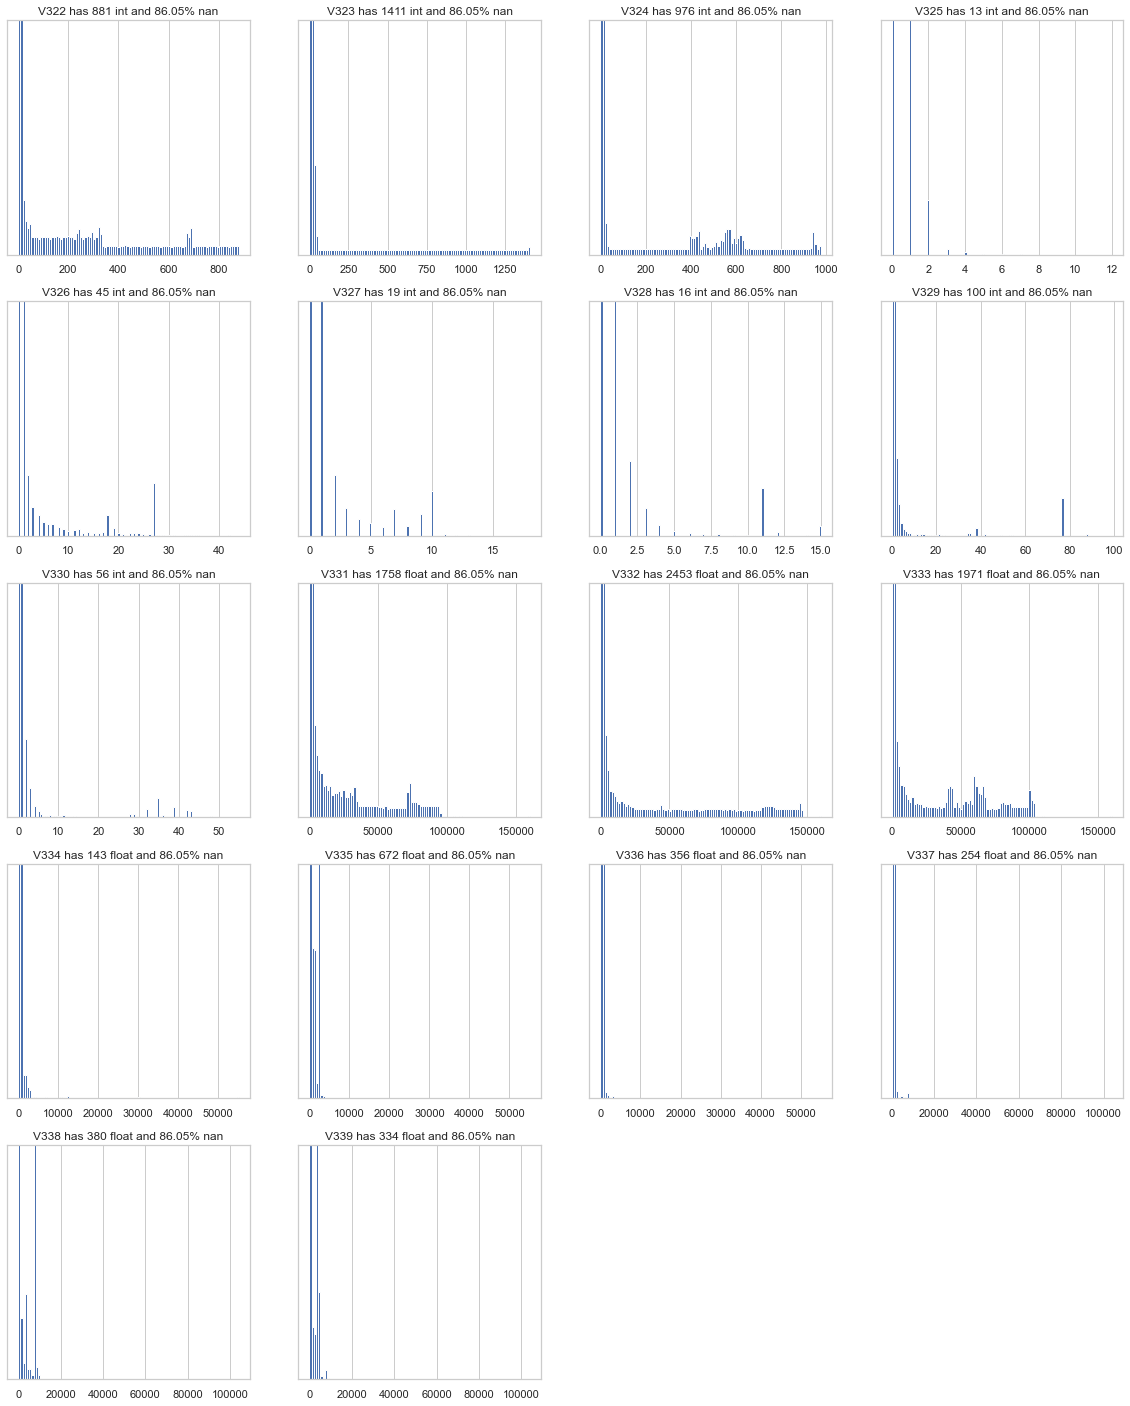

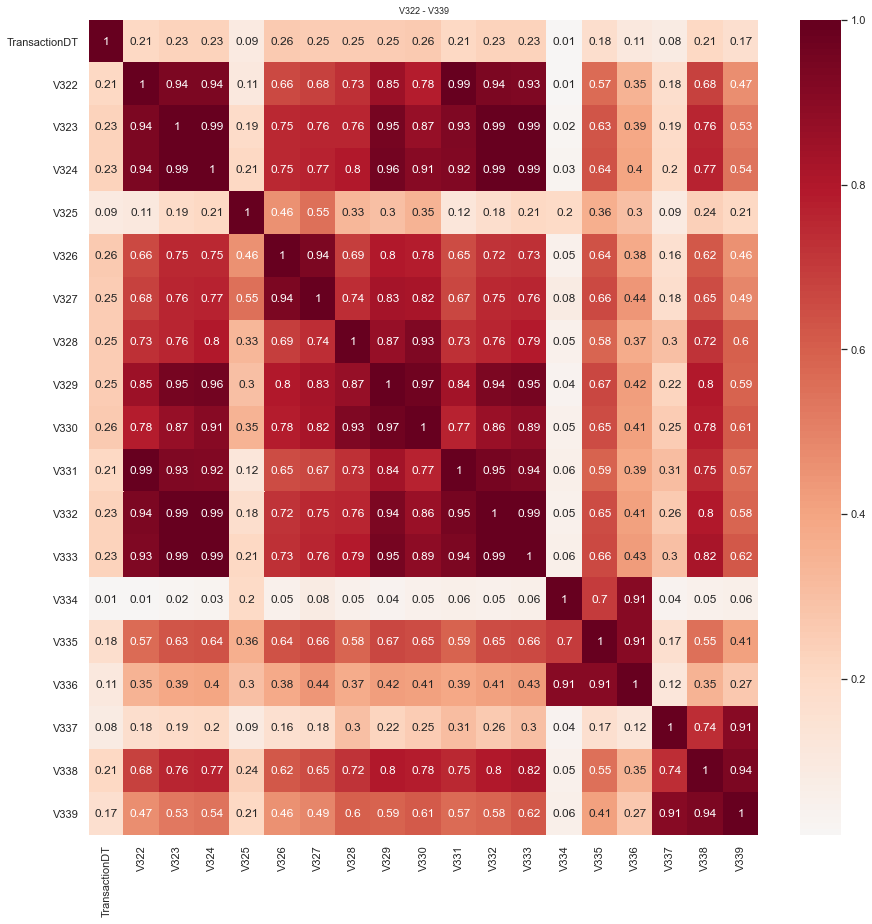

In [70]:
Vs = nans_groups[508189]
make_plots(Vs)
make_corr(Vs)

In [71]:
grps = [[322,323,324,326,327,328,329,330,331,332,333],[325],[334,335,336],[337,338,339]]
reduce_group(grps)

Use these [332, 325, 335, 338]


### V Reduced

In [72]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [73]:
print('Reduced set has',len(v),'columns')

Reduced set has 128 columns


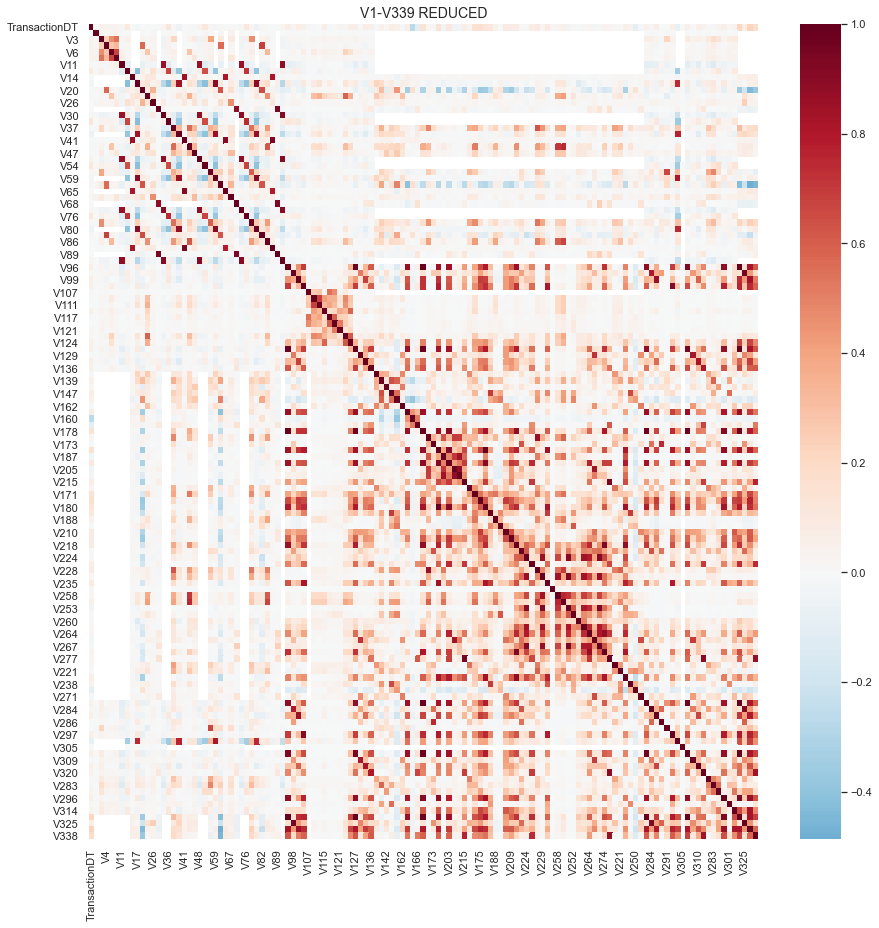

In [74]:
cols = ['TransactionDT'] + ['V'+str(x) for x in v]
train2 = train_df[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED',fontsize=14)
plt.show()

### V All

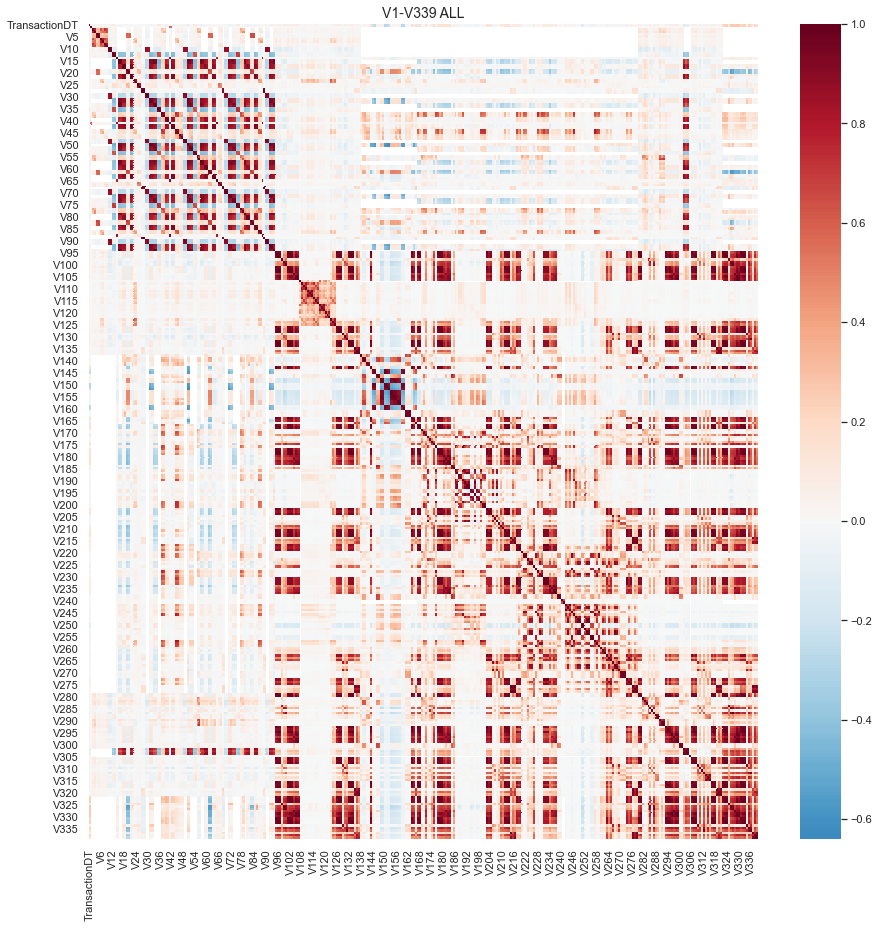

In [75]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train_df[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

## Feature Engineering 

In [76]:
# Data Merge
X_train = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
X_test = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

In [78]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
X_train['outsider15'] = (np.abs(X_train.D1n-X_train.D15n)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1n-X_test.D15n)>3).astype('int8')

In [80]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [82]:
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 

In [83]:
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.TransactionDay-X_train.D1).astype(str)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.TransactionDay-X_test.D1).astype(str)
encode_FE(X_train,X_test,['uid'])

uid_FE , 

KeyboardInterrupt: 

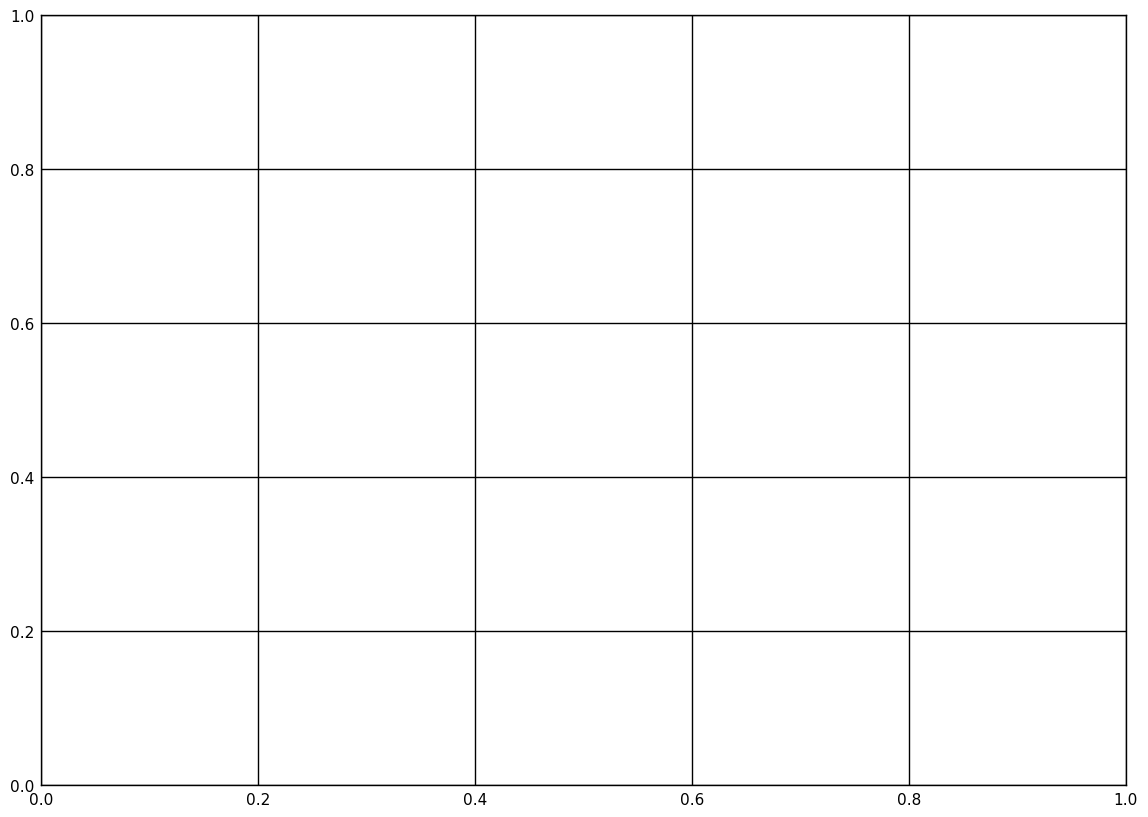

In [84]:
X_total = pd.concat([X_train, X_test], axis=0, sort=False)
X_total_ = X_total.groupby(['uid']).head(1)
X_total__ = X_total.groupby(['uid']).tail(1)
X_total = pd.concat([X_total_, X_total__], axis=0, sort=False)

del X_total_; del X_total__

(ggplot(data = X_total)
 + geom_line(aes(x='TransactionDay', y = 'D1n', group='uid'), color='blue', size=0.2)
 + geom_vline(xintercept=183, color='black')
 + geom_vline(xintercept=213, color='black')
 + geom_vline(xintercept=253, color='black')
 # + labs(title='Each blue horizontal line is one UID over time. Vertical black lines indicate train, public test, and private test.\nTrain ends on day 183. Public test begins on day 213. Private test begins on day 253')
 + theme(legend_position = "none", figure_size=(14,10))
)

![](http://playagricola.com/Kaggle/pie10419.png)

In [ ]:
encode_AG(['TransactionAmt','D9n','D11n'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)
encode_AG(['TransactionAmt','D4n','D9n','D10n','D15n'],['uid'],['mean','std'],fillna=True,usena=True)
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)

## Feature Selection 

In [ ]:
# ADD MONTH FEATURE
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 

# SPLIT DATA INTO FIRST MONTH AND LAST MONTH
train_df = train_df[train_df.DT_M==12].copy()
validate = train_df[train_df.DT_M==17].copy()

# train_df AND VALIDATE
lgbm = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
            num_leaves=8, learning_rate=0.02)

In [ ]:
score_df = pd.DataFrame()
col_list = []
auc_train_list = []
auc_val_list = []
for col in train_df.columns.tolist(): 
    h = lgbm.fit(train_df[[col]], train_df.isFraud, eval_metric='auc', 
            eval_set=[(train_df[[col]],train_df.isFraud),(validate[[col]],validate.isFraud)])
    auc_train_df = np.round(h._best_score['valid_0']['auc'],4)
    auc_val = np.round(h._best_score['valid_1']['auc'],4)
    
    col_list.append(col)
    auc_train_list.append(auc_train_df)
    auc_val_list.append(auc_val)

In [ ]:
score_df['colums'] = col_list
score_df['auc_train'] = auc_train_list
score_df['auc_valid'] = auc_val_list
score_df['auc_diff'] = np.abs(score_df['auc_train'] - score_df['auc_valid'])
score_df.sort_values(by='auc_diff', ascending=False)